# Computer Vision and Handwritten Mathematics

## Brent Fraser

### 20 September 2020 

## Introduction

This project is focused on recognizing images of handwritten mathematical equations and outputting the solution. We employ convolutional neural networks for all image classification. The logic and code below is not borrowed from any other source. The project was constructed with the intent that it be scaleable to accommodate new symbols, new equations, and longer equations. This goal introduced some problems, which we discuss later.

The structure of this notebook is similar to the method in which the project developed. The data was obtained on Kaggle at https://www.kaggle.com/michelheusser/handwritten-digits-and-operators except the MNIST data which was loaded through Keras. Data exploration in this notebook is minimal since all data is image data. We looked at several sample images before deciding to use the dataset. Another convenient feature of the Kaggle data is that it was designed to conform with the MNIST images. Namely, all images are 28 x 28 with pixel values ranging from 0 to 1. 

A large portion of the code is written to be object-oriented since there are several functions that will be used repeatedly throughout the notebook. Data synthesis and preperation is also a large portion of this project. Generating matrices with sufficient randomness form the train and test data was important to simulate real applications as well as possible. There are several issues which we will address throughout the notebook.

The three neural networks were trained as the code developed. The neural networks for matrix recognition and for symbol recognition both had six versions while the digit recognition neural network had two. This is due to the iterative process of experimentation. All code for initializing, training, and plotting accuracy and loss for each neural network remains in this notebook as commented sections. The most recent accuracy and loss plots are included after the commented sections in markdown cells.

The last portion of the notebook is the logic which parses through and solves the input image of an equation. These equations are also synthesized from randomly choosing from the Kaggle and MNIST data.

The markdown cells are organized in paragraphs which precede the relevant code. 

## Table of Contents

1. [Data Processing](#data)
2. [Convolutional Neural Network 1 - Digit Recognition](#cnn1)
3. [Data Synthesis - Matrix Data](#matrix)
4. [Convolutional Neural Network 2 - Matrix Recognition](#cnn2)
5. [Concolutional Neural Network 3 - Symbol Recognition](#cnn3) <br>
    5.1 [Data Processing and Sythesis](#cnn3data)  
    5.2 [Symbol Recognition Neural Network](#cnn3nn)    
6. [Equation Parsing and Solving](#eq)
7. [Conclusion](#conclusion)

First, we import everything we need. Any packages required were added to the first cell regardless of where they were used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Filter to blurr images
from scipy.ndimage import gaussian_filter

#For image resizing.
from skimage.transform import resize

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Standard Handwritten digits.
from tensorflow.keras.datasets import mnist

#Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import EarlyStopping

## Data Processing
<a id='data'></a>

We load in the Kaggle dataset which was already split into train, validation, and test sets. The training data has 200331 rows, the validation data has 66777 rows, and the testing data has 66778 rows. All three have two columns. The first column is a 2-dimensional numpy array of image pixels. The second column is the target classification string variable. However, we have to split the images into digits, brackets, and operations. We also store the image pixels and target variables seperately.

We also use the MNIST handwritten digits since it is easily accessible and high quality. We reshape all images to conform the MNIST 28 x 28 x 1 shape since the Kaggle data is designed for this purpose.

In [2]:
#Read in training, validation, and testing data.
train_data = np.load('data/763806_1332899_bundle_archive/CompleteDataSet_training_tuples.npy', allow_pickle = True)
validation_data = np.load('data/763806_1332899_bundle_archive/CompleteDataSet_validation_tuples.npy', allow_pickle = True)
test_data = np.load('data/763806_1332899_bundle_archive/CompleteDataSet_testing_tuples.npy', allow_pickle = True)

In [3]:
#look at the data.
train_data[:,0]

array([array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0,

In [4]:
#Check shape of data. array of arrays plus class identifier.
train_data.shape

(200331, 2)

In [5]:
#Check class identifier.
train_data[0,1]

'2'

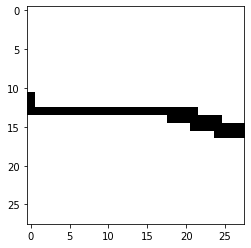

In [6]:
#Check image output.
plt.imshow(train_data[10,0], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

In [7]:
#Dictionary of classifiers by symbol type.
#Different symbols will be used for different NN models.
data_classes = {'digit' : ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'bracket' : ['[', ']'], 'operation' : ['+', '-']}

In [8]:
#Storage for data by symbol types.
train_digits = []
train_brackets = []
train_operations = []

In [9]:
#Put data into seperate arrays depending on type. We have some extra images we won't use - namely '%'.
for i in range(0, train_data.shape[0]):
    if train_data[i, 1] in data_classes['digit']:
        train_digits.append(train_data[i, :])
    elif train_data[i, 1] in data_classes['bracket']:
        train_brackets.append(train_data[i, :])
    elif train_data[i, 1] in data_classes['operation']:
        train_operations.append(train_data[i, :])        

In [10]:
#Data and target variables for digits.
X_train_digits = np.array(train_digits)[:, 0]
y_train_digits = np.array(train_digits)[:, 1]

In [11]:
#Recast digit classes as int to match with mnist.
y_train_digits = y_train_digits.astype('int32')

In [12]:
#Image dimensions of all data.
img_rows = 28
img_cols = 28

In [13]:
#Reshape digit images for NN processing as done with mnist before.
X_train_digits = np.stack(X_train_digits).reshape(X_train_digits.shape[0], img_rows, img_cols, 1)

In [14]:
#Recast pixels as floats to match mnist from before.
X_train_digits = X_train_digits.astype('float32')

In [15]:
#Data and target for other symbols.
X_train_brackets = np.array(train_brackets)[:, 0]
y_train_brackets = np.array(train_brackets)[:, 1]

X_train_operations = np.array(train_operations)[:, 0]
y_train_operations = np.array(train_operations)[:, 1]

In [16]:
#Reshaping images for other symbols as done with digits.
X_train_brackets = np.stack(X_train_brackets).reshape(X_train_brackets.shape[0], img_rows, img_cols, 1)
X_train_operations = np.stack(X_train_operations).reshape(X_train_operations.shape[0], img_rows, img_cols, 1)

In [17]:
#Recast the rest of the training pixels.
X_train_brackets = X_train_brackets.astype('float32')
X_train_operations = X_train_operations.astype('float32')

In [18]:
#Make sure pixel values range from 0 to 1.
#If largest pixel values is greater than 1, we scale the values.
ind_digits = np.unravel_index(np.argmax(X_train_digits, axis=None), X_train_digits.shape)
ind_brackets = np.unravel_index(np.argmax(X_train_brackets, axis=None), X_train_brackets.shape)
ind_operations = np.unravel_index(np.argmax(X_train_operations, axis=None), X_train_operations.shape)

if (X_train_digits[ind_digits] > 1):
    X_train_digits = X_train_digits / 255

if (X_train_brackets[ind_brackets] > 1):
    X_train_brackets = X_train_brackets / 255

if (X_train_operations[ind_operations] > 1):
    X_train_operations = X_train_operations / 255

In [19]:
#Check shape of validation and testing data. array of arrays plus class identifier.
validation_data.shape, test_data.shape

((66777, 2), (66778, 2))

In [20]:
#Storage for validation and test data by symbol types.
validation_digits = []
validation_brackets = []
validation_operations = []

test_digits = []
test_brackets = []
test_operations = []

In [21]:
#Put validation data into seperate arrays depending on type. We have some extra images we won't use - namely '%'.
for i in range(0, validation_data.shape[0]):
    if validation_data[i, 1] in data_classes['digit']:
        validation_digits.append(validation_data[i, :])
    elif validation_data[i, 1] in data_classes['bracket']:
        validation_brackets.append(validation_data[i, :])
    elif validation_data[i, 1] in data_classes['operation']:
        validation_operations.append(validation_data[i, :])

#Do this same for test data. 
#The datasets have different number of rows so the code seems clearer with tow seperate loops.
for i in range(0, test_data.shape[0]):
    if test_data[i, 1] in data_classes['digit']:
        test_digits.append(test_data[i, :])
    elif test_data[i, 1] in data_classes['bracket']:
        test_brackets.append(test_data[i, :])
    elif test_data[i, 1] in data_classes['operation']:
        test_operations.append(test_data[i, :]) 

In [22]:
#Validation data and target variables.
X_validation_digits = np.array(validation_digits)[:, 0]
y_validation_digits = np.array(validation_digits)[:, 1]

X_validation_brackets = np.array(validation_brackets)[:, 0]
y_validation_brackets = np.array(validation_brackets)[:, 1]

X_validation_operations = np.array(validation_operations)[:, 0]
y_validation_operations = np.array(validation_operations)[:, 1]

#Reshape validation images for NN processing as done with mnist before.
X_validation_digits = np.stack(X_validation_digits).reshape(X_validation_digits.shape[0], img_rows, img_cols, 1)
X_validation_brackets = np.stack(X_validation_brackets).reshape(X_validation_brackets.shape[0], img_rows, img_cols, 1)
X_validation_operations = np.stack(X_validation_operations).reshape(X_validation_operations.shape[0], img_rows, img_cols, 1)

#Recast validation digit classes as int.
y_validation_digits = y_validation_digits.astype('int32')

#Recast validation pixels as floats
X_validation_digits = X_validation_digits.astype('float32')
X_validation_brackets = X_validation_brackets.astype('float32')
X_validation_operations = X_validation_operations.astype('float32')

#Make sure pixel values range from 0 to 1.
#If pixel largest pixel value is more than 1, we scale the values.
ind_digits = np.unravel_index(np.argmax(X_validation_digits, axis=None), X_validation_digits.shape)
ind_brackets = np.unravel_index(np.argmax(X_validation_brackets, axis=None), X_validation_brackets.shape)
ind_operations = np.unravel_index(np.argmax(X_validation_operations, axis=None), X_validation_operations.shape)

if (X_validation_digits[ind_digits] > 1):
    X_validation_digits = X_validation_digits / 255

if (X_validation_brackets[ind_brackets] > 1):
    X_validation_brackets = X_validation_brackets / 255

if (X_validation_operations[ind_operations] > 1):
    X_validation_operations = X_validation_operations / 255

In [23]:
#Test data and target variables.
X_test_digits = np.array(test_digits)[:, 0]
y_test_digits = np.array(test_digits)[:, 1]

X_test_brackets = np.array(test_brackets)[:, 0]
y_test_brackets = np.array(test_brackets)[:, 1]

X_test_operations = np.array(test_operations)[:, 0]
y_test_operations = np.array(test_operations)[:, 1]

#Reshape test images for NN processing as done with mnist before.
X_test_digits = np.stack(X_test_digits).reshape(X_test_digits.shape[0], img_rows, img_cols, 1)
X_test_brackets = np.stack(X_test_brackets).reshape(X_test_brackets.shape[0], img_rows, img_cols, 1)
X_test_operations = np.stack(X_test_operations).reshape(X_test_operations.shape[0], img_rows, img_cols, 1)

#Recast test digit classes as int.
y_test_digits = y_test_digits.astype('int32')

#Recast test pixels as floats
X_test_digits = X_test_digits.astype('float32')
X_test_brackets = X_test_brackets.astype('float32')
X_test_operations = X_test_operations.astype('float32')

#Make sure pixel values range from 0 to 1.
#If pixel largest pixel value is more than 1, we scale the values.
ind_digits = np.unravel_index(np.argmax(X_test_digits, axis=None), X_test_digits.shape)
ind_brackets = np.unravel_index(np.argmax(X_test_brackets, axis=None), X_test_brackets.shape)
ind_operations = np.unravel_index(np.argmax(X_test_operations, axis=None), X_test_operations.shape)

if (X_test_digits[ind_digits] > 1):
    X_test_digits = X_test_digits / 255

if (X_test_brackets[ind_brackets] > 1):
    X_test_brackets = X_test_brackets / 255

if (X_test_operations[ind_operations] > 1):
    X_test_operations = X_test_operations / 255

Upon training the neural networks, we realized that brackets were being misclassified as operations and digits. We discovered that this is due to the fact that we trained the neural networks on unfiltered images of brackets but when constructing matrices, the bracket images get stretched. Then, to feed in these stretched brackets to be classified, they were reshaped again. This caused significant data loss. 

The first attempted remedy was to augment the bracket data with a Gaussian filter which doubled the number of bracket images and allowed the models to learn blurrier bracket images. Although the images with a Gaussian filter and the images which were reshaped twice produced visually similar results, the approach was not sufficient for training the neural networks. Thus, we augment the bracket data by reshaping the training and validation brackets as if they were fit to a 3x3 matrix then scaled to conform with the model input requirements. This ensures that we are training the networks on the same type of bracket data as we are testing.

One approach that we did not have a chance to try was using techniques to sharpen the bracket images after reshaping. We also did not add resized brackets for 2x2 matrices since reshaping to fit a 3x3 matrix should produce similar but more extreme results.

In [24]:
#We resize the brackets to match the dimensions used in building 3x3 matrices..
#Note that then the filtered brackets are already size 32x32x1 so padding will act trivially on them.

#Brackets will likely be taller than digits so they will get distorted during preprocessing.
X_train_brackets_filtered = []
X_validation_brackets_filtered = []
X_test_brackets_filtered = []

#Replace images with filtered images
for i in range(0, X_train_brackets.shape[0]):
    #X_train_brackets_filtered[i] = gaussian_filter(X_train_brackets[i], sigma = 1)
    X_train_brackets_filtered.append(resize(resize(X_train_brackets[i],(96,16,1)), (32,32,1)))
    
for i in range(0, X_validation_brackets.shape[0]):
    #X_validation_brackets_filtered[i] = gaussian_filter(X_validation_brackets[i], sigma = 1)
    X_validation_brackets_filtered.append(resize(resize(X_validation_brackets[i],(96,16,1)), (32,32,1)))
    
for i in range(0, X_test_brackets.shape[0]):
    #X_test_brackets_filtered[i] = gaussian_filter(X_test_brackets[i], sigma = 1)
    X_test_brackets_filtered.append(resize(resize(X_test_brackets[i],(96,16,1)), (32,32,1)))
    
X_train_brackets_filtered = np.array(X_train_brackets_filtered)
X_validation_brackets_filtered = np.array(X_validation_brackets_filtered)
X_test_brackets_filtered = np.array(X_test_brackets_filtered)

#Order of the brackets is preserved so target variable is the same as unfiltered data.
y_train_brackets_filtered = y_train_brackets.copy()
y_validation_brackets_filtered = y_validation_brackets.copy()
y_test_brackets_filtered = y_test_brackets.copy()

We load in the MNIST data here and process it in the standard way. We then apply a Gaussian filter. The intended outcome of applying the filter was so the digit recognition neural network could learn more of the general shape of the digits since handwriting varies greatly. We also split the training data into train and validation to fit the Kaggle data.

In [25]:
#Load the MNIST data, split between train and test sets by default.
#Other digit data is unrelated to MNIST so we can use both datasets.
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

In [26]:
#Reshape for Keras model types.
X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], img_rows, img_cols, 1)
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], img_rows, img_cols, 1)

In [27]:
#Recast pixels as floats and modify the pixel values to be in the range of 0 to 1.
#We already know the mnist data form keras needs to be scaled.
X_train_mnist = X_train_mnist.astype('float32')
X_test_mnist = X_test_mnist.astype('float32')
X_train_mnist /= 255
X_test_mnist /= 255

#Add gaussian filter to the mnist digits in an attempt to learn the general shapes of digits.
for n in range(0, X_train_mnist.shape[0]):
    X_train_mnist[n] = gaussian_filter(X_train_mnist[n], sigma = 1)

In [28]:
#Use the same validation percentage as above.
validation_pct = 0.25

#Take the validation set from the end of the training set.
validation_split = int(X_train_mnist.shape[0] * (1 - validation_pct))

In [29]:
#Split the training set into train and validation.
X_validation_mnist = X_train_mnist[validation_split : X_train_mnist.shape[0]]
X_train_mnist = X_train_mnist[0 : validation_split]

In [30]:
#Split the training target set into train and validation.
y_validation_mnist = y_train_mnist[validation_split : y_train_mnist.shape[0]]
y_train_mnist = y_train_mnist[0 : validation_split]

In [31]:
#Merge training digit data sets together.
X_train_digits = np.concatenate((X_train_digits, X_train_mnist), axis = 0)
y_train_digits = np.concatenate((y_train_digits, y_train_mnist), axis = 0)

#Merge validation digit data sets.
X_validation_digits = np.concatenate((X_validation_digits, X_validation_mnist), axis = 0)
y_validation_digits = np.concatenate((y_validation_digits, y_validation_mnist), axis = 0)

In [32]:
#Merge test digit data sets. 
X_test_digits = np.concatenate((X_test_digits, X_test_mnist), axis = 0)
y_test_digits = np.concatenate((y_test_digits, y_test_mnist), axis = 0)

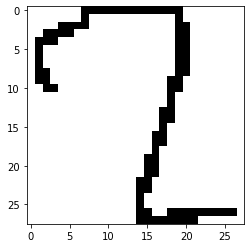

In [33]:
#Example of a digit from Kaggle data.
plt.figure()
plt.imshow(X_train_digits[0], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

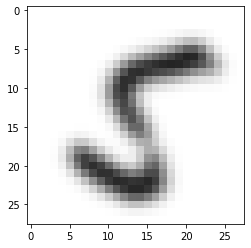

In [34]:
#Example of MNIST digit with gaussian filter.
plt.figure()
plt.imshow(X_train_digits[-1], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

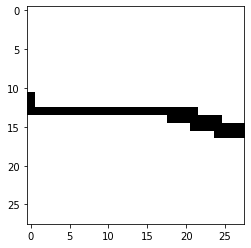

In [35]:
#Example of minus operation from Kaggle.
plt.figure()
plt.imshow(X_train_operations[0], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

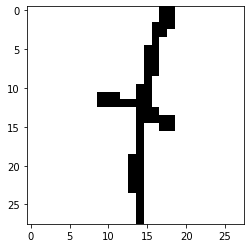

In [36]:
#Example of plus operation from Kaggle.
plt.figure()
plt.imshow(X_train_operations[3], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

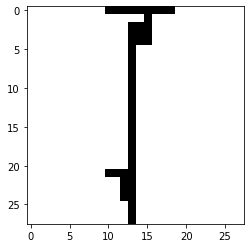

In [37]:
#Example of right bracket from Kaggle.
plt.figure()
plt.imshow(X_train_brackets[0], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

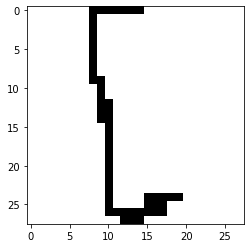

In [38]:
#Example of left bracket from Kaggle.
plt.figure()
plt.imshow(X_train_brackets[-1], cmap = 'gray_r', vmin = 0, vmax = 1)
plt.show()

Now we define five functions which we use throughout data processing, data synthesis, and parsing through input images. The functions are 'padding', 'digit_cropping', 'img_partition', 'bracket_removal', and 'synth_mat'.

The padding function is used to pad images with 0 valued pixels if the dimensions are too small for the neural network input. 

The digit_cropping function is used get the smallest square of pixels containing the digit. However, the function can be used for any image where the pixels form a connected set.

The img_partition function is the main piece of code which we used to deconstruct matrices and equations. It scans through an axis, storing the locations of the edges of connected features.

The bracket_removal function is used to removing brackets from an image. This function requires that the brackets are the outermost features.

The synth_mat function is the main piece of code which we use to construct data. It builds matrices by randomly selecting digits and brackets from input data.

In [39]:
def padding(imgs, new_size = (32, 32, 1)):
    '''
    Takes array of images, (array of pixels all with the same size), as input and padds with zeroes.
    Defualt new_size is 32x32x1 and mnist data is 28x28x1.
    
    Example: input an array of 28x28x1 images and get an array of 32x32x1 images. 
    '''
    
    #Check that the size inputs are integers.
    assert isinstance(new_size[0], int), 'Number of rows must be an integer.'
    assert isinstance(new_size[1], int), 'Number of columns must be an integer.'   
    
    #Get amount of padding for rows and columns. 
    #This assumes all images in imgs have the same dimensions
    padding = [new_size[0] - imgs[0].shape[0], new_size[1] - imgs[0].shape[1]]
    
    #Check that the amount of padding is divisible by 2.
    #assert ((np.remainder(padding[0], 2) == 0) & (np.remainder(padding[1], 2) == 0)), 'Pad each side the same amount.'
    
    #Initialize variable to store images. Pad rows first.
    padded_imgs = []
    
    #Pad the images.
    for img in imgs:
        
        #Row padding will have length given by image inputs.
        #The column padding has height given by the desired new height.
        #In case we need to pad an odd number of rows or columns, use floor and ceiling.
        row_pad1 = np.zeros((int(np.floor(padding[0] / 2)), imgs[0].shape[1], 1), np.float32)
        col_pad1 = np.zeros((new_size[0], int(np.floor(padding[1] / 2)), 1), np.float32)
        row_pad2 = np.zeros((int(np.ceil(padding[0] / 2)), imgs[0].shape[1], 1), np.float32)
        col_pad2 = np.zeros((new_size[0], int(np.ceil(padding[1] / 2)), 1), np.float32)

        pad = np.concatenate([row_pad1, img, row_pad2], axis = 0)
        pad = np.concatenate([col_pad1, pad, col_pad2], axis = 1)
        padded_imgs.append(pad)
    
    #Return an array of padded images
    return np.array(padded_imgs)

In [40]:
def digit_cropping(img):
    '''
    Input: image to be cropped.
    Output: image with white space removed from edges. 
    Can be used to crop any image, not just digits.
    
    If a row or column of pixels sums to zero, remove it.
    '''
    
    #Check horizontal axis first, then vertical axis.
    #Check is either edge along axis is blank.
    #Remove edge if blank and update image.
    #Do this until no blank edge.
    for i in [0, 1]:
        for j in [-1, 0]:
            if (i == 0):
                pix_sum = sum(img[j, :])
                while (pix_sum == 0):
                    img = np.delete(img, j, i)
                    pix_sum = sum(img[j, :])
            else:
                pix_sum = sum(img[:, j])
                while (pix_sum == 0):
                    img = np.delete(img, j, i)
                    pix_sum = sum(img[:, j])

    return img

In [41]:
def img_partition(img, dim, scan_width):
    ''' 
    Input:
    img is an 2D array representing a greyscale image and desired dimension to partition
    dim is a string denoting rows or columns
    scan_width give the thickness of scanning box we use to sum pixel values.
    
    Output: 
    an array of vertical or horizontal partition locations the seperate image components.
    
    Example, input 3x2 matrix, 'col', 2.
    Output [p1, p2] the right bounds defining each column. Parts of images separated by at most 1 black pixel are considered the same part.
    '''
    
    #Check that image has the right shape. Should be 2D. A third dimension must be 1 if it exists.
    assert (((len(img.shape) == 3) & (img.shape[2] == 1)) | (len(img.shape) == 2)), 'Image must be 2D array. Colour dimension must be 1 if present.'
    
    #Check that img is an array of floats
    for j in img:
        assert (j.dtype in (np.float32, np.float64)), 'Image pixel must have float value.'
    
    #Check partition axis is specified.
    assert ((dim == 'col') | (dim == 'row')), 'Specify dimension string "col" for column or "row" for row.'
    
    assert isinstance(scan_width, int), 'Scanning box thickness must be an integer.'
    
    assert (scan_width > 0), 'Scanning box thickness must be positive.'
    
    #Initialise variable for bookkeeping.
    dim_length = 0
    detect_img = False
    bounds = []
    
    #If counting rows, we scan down the image so we want image height.
    if (dim == 'row'):
        dim_length = img.shape[0]
    #If we are counting columns, we scan accorss the image so we want image length.
    else:
        dim_length = img.shape[1]
        
    #Check that scanning box is not too large relative to image.
    assert (scan_width < np.floor(dim_length / 2)), 'Scanning box is too large.'
    
    #Scan along desired axis and sum pixel values.
    for i in range(0, dim_length - scan_width, scan_width):
        if (dim == 'row'):
            dim_val = np.sum(img[i : i + scan_width, :])
        else:
            dim_val = np.sum(img[:, i : i + scan_width])
    
        if (dim_val > 0):
            #Sum of pixels being nonzero means some part of the image has been detected along the axis.
            detect_img = True
        else:
            #If no image is detected and there previously was an image detected,
            #store the axis value as the rightmost bound of image and continue.
            if (detect_img == True):
                detect_img = False
                bounds.append(i)
    
    #If detecting only one entry with no white space, set boundary to right edge.
    #This should only happen if scan_width is too large.
    if (len(bounds) == 0):
        bounds.append(dim_length - 1)
    
    #Check last boundary depending on axis.
    if (dim == 'row'):
        #If there is an image detected between last boundary and edge of image.
        if np.sum(img[bounds[-1] : dim_length, :]) > 0:
            #Add largest value of axis as boundary.
            bounds.append(dim_length - 1)
        else:
            #Nothing between last boundary and image edge.
            #Set the bound to be the largest value on that axis.
            bounds[-1] = dim_length - 1
    else:
        #If there is an image detected between last boundary and edge of image.
        if (np.sum(img[:, bounds[-1] : dim_length]) > 0):
            #Add largest value of axis as boundary.
            bounds.append(dim_length - 1)
        else:
            #Nothing between last boundary and image edge.
            #Set the bound to be the largest value on that axis.
            bounds[-1] = dim_length - 1
        
    return bounds

In [42]:
def bracket_removal(img):
    '''
    Brackets often partially wrap around the symbols contained within.
    This will cause significant issues for the img_partition() function.
    We take in an image of a matrix and output the image without brackets.
    This is to be applied after the neural network has decided the image is a matrix.
    
    Slice the image into horizontal strips of a fixed height. 
    Use img_partition to get the first and last pieces of the image slice.
    Each piece should be a part of the bracket. 
    Remove the bracket slices and store in a new array.
    Piece together the image without the brackets and output.
    
    Example: input an image like [b c] and get b c as output. 
    '''
    
    #Set the height of the slice. 
    slice_height = 2
    
    #Slice should divide image height.
    assert (np.remainder(img.shape[0], slice_height) == 0), 'Slice height should divide image height.'
    
    #Number of slices of the image.
    num_slices = int(img.shape[0] / slice_height)
    
    #Get partitions for each slice. Using scan_width = 1 in img_partition().
    for n in range(0, num_slices):
        #Partition slice to get location of features.
        slice_partition = img_partition(img[n * slice_height : (n + 1) * slice_height, :], 'col', 4)
        
        #Array of zeroes with the same dimensions as image slice.
        #We will store the slice with brackets removed here.
        img_slice = np.zeros((slice_height, img.shape[1], 1))
        
        #If slice_partition is of length 1, then the slice is all white space and the partition is just the last column of pixels.
        #This means we can skip and attempt to remove a part of a bracket here.
        if (len(slice_partition) > 1):
            #Left side to first partition and second last partition to right side are zero.
            #Note partition gives right edge of image piece.
            #Middle of image is the same.
            img_slice = np.hstack([np.zeros((slice_height, slice_partition[0] - 1, 1)), 
                                  img[n * slice_height : (n + 1) * slice_height, slice_partition[0] : slice_partition[-2]],
                                  np.zeros((slice_height, img.shape[1] - slice_partition[-2] + 1, 1))]) 

        #First iteration, store slice. Subsequent iterations, stack slices under.
        if (n == 0):
            img_no_brackets = img_slice
        else:
            img_no_brackets = np.vstack([img_no_brackets, img_slice])
        
    return img_no_brackets

In [43]:
def synth_mat(digits, lbrackets, rbrackets, row = 3, col = 3):
    '''
    Input images of digits and brackets. Build a matrix from randomly selected digit images and bracket images.
    Also takes matrix dimensions as integer arguments row and col. These both default to 3.
    Currently assumes there are an equal number of left and right bracket images.
    We also assume all digit images have the same size.
    '''
    
    #Check matrix dimensions are integers.
    assert isinstance(row, int), 'Number of rows must be an integer.'
    assert isinstance(col, int), 'Number of columns must be an integer.'
    
    #Number of images in each set of data.
    digit_samples = digits.shape[0]
    lbracket_samples = lbrackets.shape[0]
    rbracket_samples = rbrackets.shape[0]
    
    #Random integers to select matrix pieces by index. We will not distinguish between round and square brackets for now.
    entry_index = np.random.randint(digit_samples, size = (row, col))
    lbracket_index = np.random.randint(lbracket_samples, size = 1)
    rbracket_index = np.random.randint(rbracket_samples, size = 1)
    
    #Stack matrix entries corresponding to their position in the entry_index array.
    for i in range(0, row):
        for j in range(0, col):
            if (j == 0):
                mat_row = digits[entry_index[i, 0]]
            else:
                mat_row = np.hstack([mat_row, digits[entry_index[i, j]]])
            
        if (i == 0):
            mat = mat_row
        else:
            mat = np.vstack([mat, mat_row])

    #Height and width of bracket image after rescaling. Width set to half of average column width.
    bheight = mat.shape[0]
    bwidth =  np.floor(mat.shape[1] / (2 * row))
    
    #Resize the brackets.
    lbracket_resized = resize(lbrackets[lbracket_index][0], (bheight, bwidth))
    rbracket_resized = resize(rbrackets[rbracket_index][0], (bheight, bwidth))
    
    #Stack the brackets on the sides of the matrix.
    mat = np.hstack([lbracket_resized, mat, rbracket_resized])
    
    return mat

## Convolutional Neural Network 1 - Digit Recognition
<a id='cnn1'></a>

Now that the digit data has been processed, we train our first convolutional neural network for digit recognition. We pad the digit images to size 32 x 32 x 1 since we started by trying VGG16 architecture which requires these dimensions as a minimum input size.

The VGG16 model available through Keras has been trained on colour image data and is not suitable for the purposes of this project. Moreover, it is very slow to train. For these reasons, we use a truncated version. The convolutional layers in direct sequence increases the receptive field, as done the max pooling layers. These allow for a model which trains relatively quickly while obtaining decent accuracy. We add dropout layers to avoid overfitting. We use relu activation for all but the last layer, where we use softmax to obtain probability estimates for classification.

We did not get the chance to alter the convolution kernel or stride. We also did not get the chance to experiment with different pooling sizes or types. We used the 'Adam' optimizer and the accuracy metric to minimize loss. We also use accuracy on the validation data for stopping the training early if it does not improve by more than 0.05%. Lastly, we set the batch size to 128 and epochs to 10, although none of the models used 10 epochs.

Ideally, we would have liked to have done more experiments with different neural network architectures and parameters but the 99.3% test accuracy seemed reasonable and time was limited. 

The confusion matrix seems to indicate that 1 is predicted a bit too often but the precision and recall for every other digit is in the 0.99 - 1.00 range. We do notice that 0 seems to be extremely under-represented but the model performs reasonably well regardless. There does not seem to be any issue with over-fitting regarding 0 as the confusion matrix shows similar trends with other digits.

Lastly, we define a function, digit_eval, to process and predict digit images.

In [44]:
#Pad train, validation, and test data to fit the model input requirements.
X_train_digits_padded = padding(X_train_digits)
X_validation_digits_padded = padding(X_validation_digits)
X_test_digits_padded = padding(X_test_digits)

In [45]:
#====================================================================================================================
#Neural network for digit recognition.
#VGG16 inspired architecture. Two sets of two 3x3 convolution layers, each set followed by a 2x2 max pooling layer.
#Dense layers and dropout layers after.

#digit_recog = Sequential()

#digit_recog.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 1)))
#digit_recog.add(Conv2D(64, (3, 3), activation = 'relu'))
#digit_recog.add(MaxPooling2D(pool_size = (2, 2)))

#digit_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#digit_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#digit_recog.add(MaxPooling2D(pool_size = (2, 2)))

#digit_recog.add(Dropout(0.25))
#digit_recog.add(Flatten())
#digit_recog.add(Dense(512, activation = 'relu'))
#digit_recog.add(Dropout(0.25))
#digit_recog.add(Dense(128, activation = 'relu'))
#digit_recog.add(Dropout(0.5))
#digit_recog.add(Dense(10, activation = 'softmax'))

#Print out a summary of the network
#digit_recog.summary()
#====================================================================================================================

In [46]:
#====================================================================================================================
#Add early stopping here - stop in the next epoch if the validation accuracy does not improve by more than 0.05%
#callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience = 1, restore_best_weights = True)

#Compile the model with the desired loss function, optimizer, and metric to optimize
#digit_recog.compile(loss = 'sparse_categorical_crossentropy',
                  #optimizer = 'Adam',
                  #metrics = ['accuracy'])
#====================================================================================================================

In [47]:
#====================================================================================================================
#Train for 10 epochs with batch size 128.
#history = digit_recog.fit(X_train_digits_padded, y_train_digits,
              #batch_size = 128,
              #epochs = 10,
              #verbose = 1,
              #validation_data = (X_validation_digits_padded, y_validation_digits), callbacks = [callback])
#====================================================================================================================

In [48]:
#====================================================================================================================
#Plots to analyze model performance.

#Variables to plot.
#epochs = history.epoch
#train_loss = history.history['loss']
#val_loss = history.history['val_loss']
#train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#plt.subplots(1, 2, figsize=(10, 5))

#Plot of loss per epoch.
#plt.subplot(1, 2, 1)
#plt.plot(epochs, train_loss, label = 'train', marker = '.')
#plt.plot(epochs, val_loss, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('loss')

#Plot of accuracy per epoch.
#plt.subplot(1, 2, 2)
#plt.plot(epochs, train_acc, label = 'train', marker = '.')
#plt.plot(epochs, val_acc, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('accuracy')

#plt.show()
#====================================================================================================================

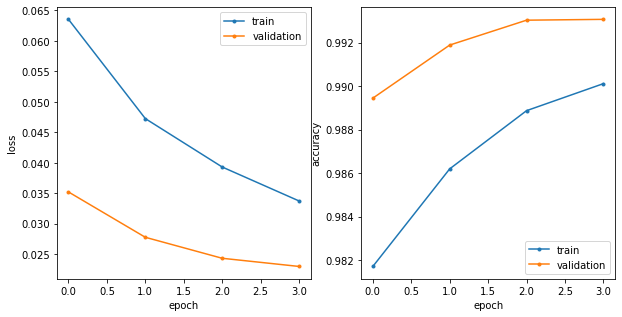

In [49]:
#====================================================================================================================
#Save the model. We can train further by loading this model in if required.
#digit_recog.save("Digit_Recognition_v2")
#====================================================================================================================

#Load version 2 of model.
digit_recog = load_model('Digit_Recognition_v2')

In [50]:
#Evaluate the model performance on the test digit data
score = digit_recog.evaluate(X_test_digits_padded, y_test_digits, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

1475/1475 [==============================] - 35s 24ms/step - loss: 0.0265 - accuracy: 0.9930
Test loss: 0.026478959247469902
Test accuracy: 0.9930047988891602


In [51]:
def digit_eval(imgs):
    '''
    Input images of digits and get the predicted classes as output.
    '''
  
    results = []
    
    for img in imgs:
        if ((img.shape[0] == 32) & (img.shape[1] == 32)):
            #If the image already has the correct dimensions, we can feed it into our model and get the class predictions.
            #The .predict requires an array input.
            result = digit_recog.predict(np.array([img]))[0]
        else:
            #Crop image to remove white space edges.
            img = digit_cropping(img)

            #Pad to get dimensions for neural network input. Predict digit class.
            result = digit_recog.predict(padding([img]))[0]
        
        #Predicted class is largest value in result array.
        #argmax returns the index corresponding to the maximum entry. Index here is the same as the class.
        prediction = np.argmax(result)

        #Store prediction.
        results.append(prediction)
        
    return np.array(results)

In [52]:
#====================================================================================================================
#Get predictions for test data.
#y_pred_digits = digit_eval(X_test_digits_padded)

#np.save('digit_test_predictions_v2', y_pred_digits, allow_pickle = True)
#====================================================================================================================
y_pred_digits = np.load('digit_test_predictions_v2.npy', allow_pickle = True)

In [53]:
#Confusion matrix.
pd.DataFrame(confusion_matrix(y_test_digits, y_pred_digits))
#model tourble: 1 being predicted too often

,0,1,2,3,4,5,6,7,8,9
0,978,0,0,0,0,0,1,1,0,0
1,0,5194,9,3,2,1,3,17,7,2
2,0,29,5003,0,3,0,0,13,3,2
3,0,1,0,5351,0,20,1,3,2,4
4,0,15,1,0,5289,0,4,4,0,18
5,0,0,0,12,0,5035,1,0,0,3
6,2,1,1,1,5,3,5020,0,3,0
7,0,38,7,8,6,1,0,4966,0,1
8,0,0,0,3,0,3,4,2,5087,8
9,0,14,3,3,7,9,0,9,3,4922


In [54]:
#Classification report.
print(classification_report(y_test_digits, y_pred_digits))
#We see 1 causes the most trouble. 7 also causes more trouble.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.98      0.99      0.99      5238
           2       1.00      0.99      0.99      5053
           3       0.99      0.99      0.99      5382
           4       1.00      0.99      0.99      5331
           5       0.99      1.00      0.99      5051
           6       1.00      1.00      1.00      5036
           7       0.99      0.99      0.99      5027
           8       1.00      1.00      1.00      5107
           9       0.99      0.99      0.99      4970

    accuracy                           0.99     47175
   macro avg       0.99      0.99      0.99     47175
weighted avg       0.99      0.99      0.99     47175



## Data Synthesis - Matrix Data
<a id='matrix'></a>

Now we move on to matrix data. We synthesize 2x2 and 3x3 matrices, each with randomly selected single digit entries. The matrices are split into train, validation, and test images so the brackets and digits are selected from the corresponding data sets. For example, the matrices for training use digits and brackets randomly selected from only the training digits and brckets. This is done to ensure that there is no data leakage.

The matrix training data is further augmented by adding a copy of each matrix after applying a Gaussian filter. We use a sigma value of 3 to produce a very blurry image. The goal is to train the neural network on the shape of the matrices instead of learning the specific digits entries. Applying the filter could potentially be avoided if more matrix data was synthesized. We only use 3,000 of each type of matrix for training. The validation and test matrices do not have any filtered matrix images since no equation image is expected to be so blurry.

When testing earlier versions of the neural network that we use for matrix recognition, there were issues with classifying operations between matrices as a matrix. For example, a plus sign in between a right bracket and a left bracket would sometimes be classified as a matrix. For this reason, we construct these column-like objects of operations in between brackets for the neural network to classify as non-matrices. We add these non-matrices in equal number to 2x2 and 3x3 matrices. For the training set, we also use the Gaussian filter in the same way.

Currently, we have 60,000 training images, split equally between five classes: matrices, digits, left brackets, right brackets, and operations between brackets. We also have 15,000 validation images and 15,000 test images, all with the same equal split between classes. All datasets for this neural network contain the 'filtered' and 'unfiltered' bracket data since we end up using the filtered brackets in matrix construction.

Note that, although we split left brackets and right brackets, we end up not distinguishing between them. This will be discussed later when commenting on results.

In [55]:
#Split up brackets for training matrix generation.
#Note we use training set of brackets here.
#Split filtered brackets as well to be added to NN data.
lbrackets = []
rbrackets = []
lbrackets_filtered = []
rbrackets_filtered = []

#Order of both sets of brackets is the same so we only need to check one target variable.
for i in range(0, X_train_brackets.shape[0]):
    if (y_train_brackets[i] == '['):
        lbrackets.append(X_train_brackets[i])
        lbrackets_filtered.append(X_train_brackets_filtered[i])
    else:
        rbrackets.append(X_train_brackets[i])
        rbrackets_filtered.append(X_train_brackets_filtered[i])

In [56]:
#====================================================================================================================
#Generate 1000 random 3x3 matrices
#X_train_3x3 = []
#for i in range(0,1000):
    #X_train_3x3.append(synth_mat(X_train_digits_padded, np.array(lbrackets), np.array(rbrackets)))
    
#np.save('matrix_train3_3x3', X_train_3x3, allow_pickle = True)
#====================================================================================================================

#Load 3x3 training matrices.
X_train1_3x3 = np.array(np.load('matrix_train_3x3.npy', allow_pickle = True))
X_train2_3x3 = np.array(np.load('matrix_train2_3x3.npy', allow_pickle = True))
X_train3_3x3 = np.array(np.load('matrix_train3_3x3.npy', allow_pickle = True))
X_train_3x3 = np.vstack([X_train1_3x3, X_train2_3x3, X_train3_3x3])

In [57]:
#Generate operations with white space on top to match how they are glued together in an equation image.
op_cols_train_3x3 = []
op_cols_train_2x2 = []
for i in range(0, X_train_operations.shape[0]):
    op_cols_train_3x3.append(np.vstack([np.zeros((64, 32, 1)), padding(np.array([X_train_operations[i]]))[0]]))
    op_cols_train_2x2.append(np.vstack([np.zeros((32, 32, 1)), padding(np.array([X_train_operations[i]]))[0]]))
    
op_cols_train_3x3 = np.array(op_cols_train_3x3)
op_cols_train_2x2 = np.array(op_cols_train_2x2)

In [58]:
#Generate 3000 random non-matrices for operations in between 3x3 matrices and 2x2 matrices.
#We can use our synth_mat() function but pass in operations instead of digits and switch the bracket order.
#The 'matrix' size is 1x1 because we already stacked the 'entries' together.
#X_train_not_3x3 = []
#X_train_not_2x2 = []
#for i in range(0,3000):
    #X_train_not_3x3.append(synth_mat(op_cols_train_3x3, np.array(rbrackets), np.array(lbrackets), 1, 1))
    #X_train_not_2x2.append(synth_mat(op_cols_train_2x2, np.array(rbrackets), np.array(lbrackets), 1, 1))
    
#np.save('matrix_train_not_3x3', X_train_not_3x3, allow_pickle = True)
#np.save('matrix_train_not_2x2', X_train_not_2x2, allow_pickle = True)
#====================================================================================================================

X_train_not_3x3 = np.array(np.load('matrix_train_not_3x3.npy', allow_pickle = True))
X_train_not_2x2 = np.array(np.load('matrix_train_not_2x2.npy', allow_pickle = True))

In [59]:
#====================================================================================================================
#Generate 1000 random 2x2 matrices
#X_train_2x2 = []
#for i in range(0,1000):
    #X_train_2x2.append(synth_mat(X_train_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2))

#np.save('matrix_train3_2x2', X_train_2x2, allow_pickle = True)
#====================================================================================================================

#Load 2x2 training matrices.
X_train1_2x2 = np.array(np.load('matrix_train_2x2.npy', allow_pickle = True))
X_train2_2x2 = np.array(np.load('matrix_train2_2x2.npy', allow_pickle = True))
X_train3_2x2 = np.array(np.load('matrix_train3_2x2.npy', allow_pickle = True))
X_train_2x2 = np.vstack([X_train1_2x2, X_train2_2x2, X_train3_2x2])

In [60]:
#Get brackets in dimensions for NN.
lbrackets = padding(np.array(lbrackets))
rbrackets = padding(np.array(rbrackets))
lbrackets_filtered = padding(np.array(lbrackets_filtered))
rbrackets_filtered = padding(np.array(rbrackets_filtered))

#Generate the other "non-matrices" equal in quantity to matrices.
#All categories represented equally.
num_train_mat = 2 * (X_train_3x3.shape[0] + X_train_2x2.shape[0])
num_digits =  num_train_mat 
num_lbrackets = int(np.floor(num_train_mat / 2))
num_rbrackets = int(np.ceil(num_train_mat / 2))

#Generate the data randomly by index.
digit_index = np.random.randint(X_train_digits_padded.shape[0], size = num_digits)
lbracket_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)
#Add an equal number of filtered brackets as unfiltered brackets since we do not have many added to begin with.
lbracket_filtered_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_filtered_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)

#Data describing what is not a matrix.
X_train_not_mat = np.vstack([X_train_digits_padded[digit_index], lbrackets[lbracket_index], lbrackets_filtered[lbracket_filtered_index], rbrackets[rbracket_index], rbrackets_filtered[rbracket_filtered_index]])

#Target variable for matrix detection.
y_train_mat = np.vstack([np.full((num_train_mat, 1), 'm'), np.full((num_digits, 1), 'd'), np.full((2 * num_lbrackets, 1), 'l'), np.full((2 * num_rbrackets, 1), 'r')])

In [61]:
X_train_not_mat_cols = []

#Add the non-matrix columns along and the columns with a gaussian filter.
for i in range(0, X_train_not_3x3.shape[0]):
    X_train_not_mat_cols.append(resize(gaussian_filter(X_train_not_3x3[i], sigma=3), (32, 32, 1)))
    X_train_not_mat_cols.append(resize(X_train_not_3x3[i], (32, 32, 1)))
    
for i in range(0, X_train_not_2x2.shape[0]):
    X_train_not_mat_cols.append(resize(gaussian_filter(X_train_not_2x2[i], sigma=3), (32, 32, 1)))
    X_train_not_mat_cols.append(resize(X_train_not_2x2[i], (32, 32, 1)))
    
X_train_not_mat_cols = np.array(X_train_not_mat_cols)

In [62]:
X_train_not_mat_cols.shape

(12000, 32, 32, 1)

In [63]:
#Add the column-like objects to the non-matrix training data.
X_train_not_mat = np.vstack([X_train_not_mat, X_train_not_mat_cols])
#Add corresponding target variables.
#Use 'o' to denote operations.
y_train_mat = np.vstack([y_train_mat, np.full((X_train_not_mat_cols.shape[0], 1), 'o')])

In [64]:
X_train_mat = []

#Adding matrices with a gaussian filter to try and extract the shape of the matrix and not the digit entries.
for i in range(0, X_train_3x3.shape[0]):
    X_train_mat.append(resize(gaussian_filter(X_train_3x3[i], sigma=3), (32, 32, 1)))
    X_train_mat.append(resize(X_train_3x3[i], (32, 32, 1)))
    
for i in range(0, X_train_2x2.shape[0]):
    X_train_mat.append(resize(gaussian_filter(X_train_2x2[i], sigma=3), (32, 32, 1)))
    X_train_mat.append(resize(X_train_2x2[i], (32, 32, 1)))
    
X_train_mat = np.array(X_train_mat)

In [65]:
#Put data together in order corresponding to target variable.
X_train_mat = np.vstack([X_train_mat, X_train_not_mat])

In [66]:
X_train_mat.shape, y_train_mat.shape

((60000, 32, 32, 1), (60000, 1))

In [67]:
#Split up brackets for validation matrix generation.
#Note we use validation set of brackets here.
#Split filtered brackets as well to be added to NN data.
lbrackets = []
rbrackets = []
lbrackets_filtered = []
rbrackets_filtered = []

for i in range(0, X_validation_brackets.shape[0]):
    if (y_validation_brackets[i] == '['):
        lbrackets.append(X_validation_brackets[i])
        lbrackets_filtered.append(X_validation_brackets_filtered[i])
    else:
        rbrackets.append(X_validation_brackets[i])
        rbrackets_filtered.append(X_validation_brackets_filtered[i])

In [68]:
#====================================================================================================================
#Generate 500 random 3x3 matrices
#X_validation_3x3 = []
#for i in range(0,500):
    #X_validation_3x3.append(synth_mat(X_validation_digits_padded, np.array(lbrackets), np.array(rbrackets)))
    
#np.save('matrix_validation3_3x3', X_validation_3x3, allow_pickle = True)
#====================================================================================================================

#Load 3x3 validation matrices.
X_validation1_3x3 = np.array(np.load('matrix_validation_3x3.npy', allow_pickle = True))
X_validation2_3x3 = np.array(np.load('matrix_validation2_3x3.npy', allow_pickle = True))
X_validation3_3x3 = np.array(np.load('matrix_validation3_3x3.npy', allow_pickle = True))
X_validation_3x3 = np.vstack([X_validation1_3x3, X_validation2_3x3, X_validation3_3x3])

In [69]:
#====================================================================================================================
#Generate 500 random 2x2 matrices
#X_validation_2x2 = []
#for i in range(0,500):
    #X_validation_2x2.append(synth_mat(X_validation_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2))
    
#np.save('matrix_validation3_2x2', X_validation_2x2, allow_pickle = True)
#====================================================================================================================

#Load 2x2 validation matrices.
X_validation1_2x2 = np.array(np.load('matrix_validation_2x2.npy', allow_pickle = True))
X_validation2_2x2 = np.array(np.load('matrix_validation2_2x2.npy', allow_pickle = True))
X_validation3_2x2 = np.array(np.load('matrix_validation3_2x2.npy', allow_pickle = True))
X_validation_2x2 = np.vstack([X_validation1_2x2, X_validation2_2x2, X_validation3_2x2])

In [70]:
op_cols_validation_3x3 = []
op_cols_validation_2x2 = []
for i in range(0, X_validation_operations.shape[0]):
    op_cols_validation_3x3.append(np.vstack([np.zeros((64, 32, 1)), padding(np.array([X_validation_operations[i]]))[0]]))
    op_cols_validation_2x2.append(np.vstack([np.zeros((32, 32, 1)), padding(np.array([X_validation_operations[i]]))[0]]))
    
op_cols_validation_3x3 = np.array(op_cols_validation_3x3)
op_cols_validation_2x2 = np.array(op_cols_validation_2x2)

In [71]:
#Generate 1500 random non-matrices for operations in between 3x3 matrices and 2x2 matrices.
#We can use our synth_mat() function but pass in operations instead of digits and switch the bracket order.
#The 'matrix' size is 1x1 because we already stacked the 'entries' together.
#X_validation_not_3x3 = []
#X_validation_not_2x2 = []
#for i in range(0,1500):
    #X_validation_not_3x3.append(synth_mat(op_cols_validation_3x3, np.array(rbrackets), np.array(lbrackets), 1, 1))
    #X_validation_not_2x2.append(synth_mat(op_cols_validation_2x2, np.array(rbrackets), np.array(lbrackets), 1, 1))
    
#np.save('matrix_validation_not_3x3', X_validation_not_3x3, allow_pickle = True)
#np.save('matrix_validation_not_2x2', X_validation_not_2x2, allow_pickle = True)
#====================================================================================================================

X_validation_not_3x3 = np.array(np.load('matrix_validation_not_3x3.npy', allow_pickle = True))
X_validation_not_2x2 = np.array(np.load('matrix_validation_not_2x2.npy', allow_pickle = True))

In [72]:
#Get brackets in dimensions for NN.
lbrackets = padding(np.array(lbrackets))
rbrackets = padding(np.array(rbrackets))
lbrackets_filtered = padding(np.array(lbrackets_filtered))
rbrackets_filtered = padding(np.array(rbrackets_filtered))

#Generate "non-matrices" equal in quantity to matrices.
#All categories represented equally.
num_validation_mat = X_validation_3x3.shape[0] + X_validation_2x2.shape[0]
num_digits =  num_validation_mat 
num_lbrackets = int(np.floor(num_validation_mat / 2))
num_rbrackets = int(np.ceil(num_validation_mat / 2))

#Generate the data randomly by index.
digit_index = np.random.randint(X_validation_digits_padded.shape[0], size = num_digits)
lbracket_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)
#Add an equal number of filtered brackets as unfiltered brackets since we do not have many added to begin with.
lbracket_filtered_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_filtered_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)

#Data describing what is not a matrix.
X_validation_not_mat = np.vstack([X_validation_digits_padded[digit_index], lbrackets[lbracket_index], lbrackets_filtered[lbracket_filtered_index], rbrackets[rbracket_index], rbrackets_filtered[rbracket_filtered_index]])

#Target variable for matrix detection.
y_validation_mat = np.vstack([np.full((num_validation_mat, 1), 'm'), np.full((num_digits, 1), 'd'), np.full((2 * num_lbrackets, 1), 'l'), np.full((2 * num_rbrackets, 1), 'r')])

In [73]:
X_validation_not_mat_cols = []

#Add the non-matrix columns.
for i in range(0, X_validation_not_3x3.shape[0]):
    X_validation_not_mat_cols.append(resize(X_validation_not_3x3[i], (32, 32, 1)))
    
for i in range(0, X_validation_not_2x2.shape[0]):
    X_validation_not_mat_cols.append(resize(X_validation_not_2x2[i], (32, 32, 1)))
    
X_validation_not_mat_cols = np.array(X_validation_not_mat_cols)

In [74]:
#Add the column-like objects to the non-matrix training data.
X_validation_not_mat = np.vstack([X_validation_not_mat, X_validation_not_mat_cols])
#Add corresponding target variables.
#Use 'o' to denote operations.
y_validation_mat = np.vstack([y_validation_mat, np.full((X_validation_not_mat_cols.shape[0], 1), 'o')])

In [75]:
X_validation_mat = []

#We do not add a gaussian filter for the validation set.
for i in range(0, X_validation_3x3.shape[0]):   
    X_validation_mat.append(resize(X_validation_3x3[i], (32, 32, 1)))
    
for i in range(0, X_validation_2x2.shape[0]):
    X_validation_mat.append(resize(X_validation_2x2[i], (32, 32, 1)))
    
X_validation_mat = np.array(X_validation_mat)

In [76]:
#Put data together in order corresponding to target variable.
X_validation_mat = np.vstack([X_validation_mat, X_validation_not_mat])

In [77]:
X_validation_mat.shape, y_validation_mat.shape

((15000, 32, 32, 1), (15000, 1))

In [78]:
#Split up brackets for test matrix generation.
#Note we use test set of brackets here.
#Split filtered brackets as well to be added to NN data.
lbrackets = []
rbrackets = []
lbrackets_filtered = []
rbrackets_filtered = []

for i in range(0, X_test_brackets.shape[0]):
    if (y_test_brackets[i] == '['):
        lbrackets.append(X_test_brackets[i])
        lbrackets_filtered.append(X_test_brackets_filtered[i])
    else:
        rbrackets.append(X_test_brackets[i])
        rbrackets_filtered.append(X_test_brackets_filtered[i])

In [79]:
#====================================================================================================================
#Generate 500 random 3x3 matrices
#X_test_3x3 = []
#for i in range(0,500):
    #X_test_3x3.append(synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets)))
    
#np.save('matrix_test3_3x3', X_test_3x3, allow_pickle = True)
#====================================================================================================================

#Load 3x3 test matrices.
X_test1_3x3 = np.array(np.load('matrix_test_3x3.npy', allow_pickle = True))
X_test2_3x3 = np.array(np.load('matrix_test2_3x3.npy', allow_pickle = True))
X_test3_3x3 = np.array(np.load('matrix_test3_3x3.npy', allow_pickle = True))
X_test_3x3 = np.vstack([X_test1_3x3, X_test2_3x3, X_test3_3x3])

In [80]:
#====================================================================================================================
#Generate 500 random 2x2 matrices
#X_test_2x2 = []
#for i in range(0,500):
    #X_test_2x2.append(synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2))
    
#np.save('matrix_test3_2x2', X_test_2x2, allow_pickle = True)
#====================================================================================================================

#Load 2x2 test matrices.
X_test1_2x2 = np.array(np.load('matrix_test_2x2.npy', allow_pickle = True))
X_test2_2x2 = np.array(np.load('matrix_test2_2x2.npy', allow_pickle = True))
X_test3_2x2 = np.array(np.load('matrix_test3_2x2.npy', allow_pickle = True))
X_test_2x2 = np.vstack([X_test1_2x2, X_test2_2x2, X_test3_2x2])

In [81]:
op_cols_test_3x3 = []
op_cols_test_2x2 = []
for i in range(0, X_test_operations.shape[0]):
    op_cols_test_3x3.append(np.vstack([np.zeros((64, 32, 1)), padding(np.array([X_test_operations[i]]))[0]]))
    op_cols_test_2x2.append(np.vstack([np.zeros((32, 32, 1)), padding(np.array([X_test_operations[i]]))[0]]))
    
op_cols_test_3x3 = np.array(op_cols_test_3x3)
op_cols_test_2x2 = np.array(op_cols_test_2x2)

In [82]:
#Generate 1500 random non-matrices for operations in between 3x3 matrices and 2x2 matrices.
#We can use our synth_mat() function but pass in operations instead of digits and switch the bracket order.
#The 'matrix' size is 1x1 because we already stacked the 'entries' together.
#X_test_not_3x3 = []
#X_test_not_2x2 = []
#for i in range(0,1500):
    #X_test_not_3x3.append(synth_mat(op_cols_test_3x3, np.array(rbrackets), np.array(lbrackets), 1, 1))
    #X_test_not_2x2.append(synth_mat(op_cols_test_2x2, np.array(rbrackets), np.array(lbrackets), 1, 1))
    
#np.save('matrix_test_not_3x3', X_test_not_3x3, allow_pickle = True)
#np.save('matrix_test_not_2x2', X_test_not_2x2, allow_pickle = True)
#====================================================================================================================

X_test_not_3x3 = np.array(np.load('matrix_test_not_3x3.npy', allow_pickle = True))
X_test_not_2x2 = np.array(np.load('matrix_test_not_2x2.npy', allow_pickle = True))

In [83]:
#Get brackets in dimensions for NN.
lbrackets = padding(np.array(lbrackets))
rbrackets = padding(np.array(rbrackets))
lbrackets_filtered = padding(np.array(lbrackets_filtered))
rbrackets_filtered = padding(np.array(rbrackets_filtered))

#Generate "non-matrices" equal in quantity to matrices.
#All categories represented equally.
num_test_mat = X_test_3x3.shape[0] + X_test_2x2.shape[0]
num_digits =  num_test_mat #int(np.floor(num_test_mat / 2))
num_lbrackets = int(np.floor(num_test_mat / 2))
num_rbrackets = int(np.ceil(num_test_mat / 2))

#Generate the data randomly by index.
digit_index = np.random.randint(X_test_digits_padded.shape[0], size = num_digits)
lbracket_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)
#Add an equal number of filtered brackets as unfiltered brackets since we do not have many added to begin with.
lbracket_filtered_index = np.random.randint(lbrackets.shape[0], size = num_lbrackets)
rbracket_filtered_index = np.random.randint(rbrackets.shape[0], size = num_rbrackets)

#Data describing what is not a matrix.
X_test_not_mat = np.vstack([X_test_digits_padded[digit_index], lbrackets[lbracket_index], lbrackets_filtered[lbracket_filtered_index], rbrackets[rbracket_index], rbrackets_filtered[rbracket_filtered_index]])

#Target variable for matrix detection.
y_test_mat = np.vstack([np.full((num_test_mat, 1), 'm'), np.full((num_digits, 1), 'd'), np.full((2 * num_lbrackets, 1), 'l'), np.full((2 * num_rbrackets, 1), 'r')])

In [84]:
X_test_not_mat_cols = []

#Add the non-matrix columns.
for i in range(0, X_test_not_3x3.shape[0]):
    X_test_not_mat_cols.append(resize(X_test_not_3x3[i], (32, 32, 1)))
    
for i in range(0, X_test_not_2x2.shape[0]):
    X_test_not_mat_cols.append(resize(X_test_not_2x2[i], (32, 32, 1)))
    
X_test_not_mat_cols = np.array(X_test_not_mat_cols)

In [85]:
#Add the column-like objects to the non-matrix test data.
X_test_not_mat = np.vstack([X_test_not_mat, X_test_not_mat_cols])
#Add corresponding target variables.
#Use 'o' to denote operations.
y_test_mat = np.vstack([y_test_mat, np.full((X_test_not_mat_cols.shape[0], 1), 'o')])

In [86]:
X_test_mat = []

#We do not add a gaussian filter for the test set.
for i in range(0, X_test_3x3.shape[0]):
    X_test_mat.append(resize(X_test_3x3[i], (32, 32, 1)))
    
for i in range(0, X_test_2x2.shape[0]):
    X_test_mat.append(resize(X_test_2x2[i], (32, 32, 1)))
    
X_test_mat = np.array(X_test_mat)

In [87]:
#Put data together in order corresponding to target variable.
X_test_mat = np.vstack([X_test_mat, X_test_not_mat])

In [88]:
X_test_mat.shape, y_test_mat.shape

((15000, 32, 32, 1), (15000, 1))

## Convolutional Neural Network 2 - Matrix Recognition
<a id='cnn2'></a>

The target variable classes are not integers so we use the one-hot-encoder to obtain the five dummy variables and categorical crossentropy instead of sparse categorical crossentropy to measure loss. The architecture and other parameters of this nerual network is the same as the network for digit recognition. This was the first neural network we tried for matrix recognition but since the results seemed decent and it trains quickly, we did not try anything else.

We end up with a 98.8% test accuracy which is the lowest of our three neural networks. However, the confusion matrix shows perfect results in classifying matrices and the non-matrix columns. The issues arise in predicting brackets. The fact that matrix detecting here has made no errors may indicate that there is not enough data. The solution is to simply generate more matrices and non-matrix data and retrain the model. It is worth noting that more data was added as the project evolved. In fact, we trained the first version on only 1000 train and 500 validation matrices of each type.  

In [89]:
#Use a one-hot-encoder on target variables. 
#Note that the encoder aranges dummy variables in alphabetical order.
#Thus the output vector is of the form ('d', 'l', 'm', 'o', 'r').
hec = OneHotEncoder()
hec.fit(y_train_mat)
y_train_mat_1h = hec.transform(y_train_mat).toarray()

In [90]:
#hec = OneHotEncoder()
#hec.fit(y_validation_mat)
y_validation_mat_1h = hec.transform(y_validation_mat).toarray()

In [91]:
#hec.fit(y_validation_mat)
y_test_mat_1h = hec.transform(y_test_mat).toarray()

In [92]:
#====================================================================================================================
#Neural network for matrix recognition.
#VGG16 inspired architecture. Two sets of two 3x3 convolution layers, each set followed by a 2x2 max pooling layer.
#Dense layers and dropout layers after.

#matrix_recog = Sequential()

#matrix_recog.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 1)))
#matrix_recog.add(Conv2D(64, (3, 3), activation = 'relu'))
#matrix_recog.add(MaxPooling2D(pool_size = (2, 2)))

#matrix_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#matrix_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#matrix_recog.add(MaxPooling2D(pool_size = (2, 2)))

#matrix_recog.add(Dropout(0.25))
#matrix_recog.add(Flatten())
#matrix_recog.add(Dense(512, activation = 'relu'))
#matrix_recog.add(Dropout(0.25))
#matrix_recog.add(Dense(128, activation = 'relu'))
#matrix_recog.add(Dropout(0.5))
#matrix_recog.add(Dense(5, activation = 'softmax'))

#Print out a summary of the network
#matrix_recog.summary()
#====================================================================================================================

In [93]:
#====================================================================================================================
#Add early stopping here - stop in the next epoch if the validation accuracy does not improve by more than 0.05%
#callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience = 1, restore_best_weights = True)

#Compile the model with the desired loss function, optimizer, and metric to optimize
#matrix_recog.compile(loss = 'categorical_crossentropy',
                  #optimizer = 'Adam',
                  #metrics = ['accuracy'])
#====================================================================================================================

In [94]:
#====================================================================================================================
#Train for 10 epochs with batch size 128.
#history = matrix_recog.fit(X_train_mat, y_train_mat_1h,
              #batch_size = 128,
              #epochs = 10,
              #verbose = 1,
              #validation_data = (X_validation_mat, y_validation_mat_1h), callbacks = [callback])
#====================================================================================================================

In [95]:
#====================================================================================================================
#Plots to analyze model performance.

#Variables to plot.
#epochs = history.epoch
#train_loss = history.history['loss']
#val_loss = history.history['val_loss']
#train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#plt.subplots(1, 2, figsize=(10, 5))

#Plot of loss per epoch.
#plt.subplot(1, 2, 1)
#plt.plot(epochs, train_loss, label = 'train', marker = '.')
#plt.plot(epochs, val_loss, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('loss')

#Plot of accuracy per epoch.
#plt.subplot(1, 2, 2)
#plt.plot(epochs, train_acc, label = 'train', marker = '.')
#plt.plot(epochs, val_acc, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('accuracy')

#plt.show()
#====================================================================================================================

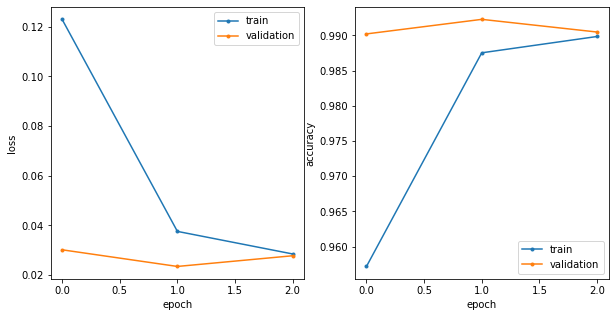

In [96]:
#====================================================================================================================
#Save the model. We can train further by loading this model in if required.
#matrix_recog.save("Matrix_Recognition_v6")
#====================================================================================================================

#Load version 6 of model.
matrix_recog = load_model('Matrix_Recognition_v6')

In [97]:
#Evaluate the model performance on the test matrix data
score = matrix_recog.evaluate(X_test_mat, y_test_mat_1h, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

469/469 [==============================] - 12s 26ms/step - loss: 0.0317 - accuracy: 0.9903
Test loss: 0.03174544498324394
Test accuracy: 0.9903333187103271


In [98]:
#====================================================================================================================
#Get predictions for test data.
#Same logic as digit_eval() but we already know the image sizes.
#y_pred_mat = []
mat_classes = np.array(['d', 'l', 'm', 'o', 'r']) #Order they are encoded by one-hot-encoder.

#for mat in X_test_mat:
    #result = matrix_recog.predict(np.array([mat]))[0]
    #prediction_index = np.argmax(result)
    #y_pred_mat.append(mat_classes[prediction_index])

#y_pred_mat = np.array(y_pred_mat)    

#np.save('matrix_test_predictions_v5', y_pred_mat, allow_pickle = True)
#====================================================================================================================
#Load predictions for version 5. Corresponds to NN version 6.
y_pred_mat = np.load('matrix_test_predictions_v5.npy', allow_pickle = True)

In [99]:
#Confusion matrix. Order is digit, left bracket, matrix, right bracket
pd.DataFrame(confusion_matrix(y_test_mat, y_pred_mat))
#Very good for matrices. We may not have enough variation in the data.

,0,1,2,3,4
0,2916,26,0,0,58
1,5,2951,0,0,44
2,0,0,3000,0,0
3,0,0,0,3000,0
4,14,10,0,0,2976


In [100]:
#Classification report.
print(classification_report(y_test_mat, y_pred_mat))

              precision    recall  f1-score   support

           d       0.99      0.97      0.98      3000
           l       0.99      0.98      0.99      3000
           m       1.00      1.00      1.00      3000
           o       1.00      1.00      1.00      3000
           r       0.97      0.99      0.98      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



## Convolutional Neural Network 3 - Symbol Recognition
<a id='cnn3'></a>

### Data Processing and Synthesis
<a id='cnn3data'></a>

As with the matrix data, we require some additional images before we can train our final neural network. The original goal here was to classify digits without distinguishing between them, left and right brackets as well as plus and minus signs. Brackets were an issue here again as they were being confused with matrix columns and the plus and minus operations. Thus, we synthesize matrix columns to add as a sixth class. 

Since there are not as many operation images, we double the number of images by adding copies with a Gaussian filter applied. We also have the filtered versus unfiltered brackets from earlier. We add an equal number of columns and digits, half of the number of symbols. Half of the columns are 2x1 and the other half are 3x1. When reviewing the performance in the context of a whole equation, we likely added too much digit-related data The training dataset has about 200,000 images comprised of approximately 50,000 digits, 50,000 columns, 25,000 left brackets, 25,000 right brackets, 25,000 plus signs, and 25,000 minus signs. The validation and test data have the same class proportions and are both aproximately 25% of the training dataset. 

In [101]:
#Add filtered operations to even out data proportions.
X_train_operations_filtered = X_train_operations.copy()
X_validation_operations_filtered = X_validation_operations.copy()
X_test_operations_filtered = X_test_operations.copy()

for i in range(0, X_train_operations.shape[0]):
    X_train_operations_filtered[i] = gaussian_filter(X_train_operations[i], sigma = 1)

for i in range(0, X_validation_operations.shape[0]):
    X_validation_operations_filtered[i] = gaussian_filter(X_validation_operations[i], sigma = 1)
    
for i in range(0, X_test_operations.shape[0]):
    X_test_operations_filtered[i] = gaussian_filter(X_test_operations[i], sigma = 1)

#Target variables are the same as unfiltered since order is preserved.
y_train_operations_filtered = y_train_operations.copy()
y_validation_operations_filtered = y_validation_operations.copy()
y_test_operations_filtered = y_test_operations.copy()

In [102]:
#Get train, validation, and test symbols in correct shape for NN.
#Add the brackets and other symbols with gaussian filter.
X_train_brackets_padded = np.vstack([padding(X_train_brackets), X_train_brackets_filtered])
X_validation_brackets_padded = np.vstack([padding(X_validation_brackets), X_validation_brackets_filtered])
X_test_brackets_padded = np.vstack([padding(X_test_brackets), X_test_brackets_filtered])

X_train_operations_padded = padding(np.vstack([X_train_operations, X_train_operations_filtered]))
X_validation_operations_padded = padding(np.vstack([X_validation_operations, X_validation_operations_filtered]))
X_test_operations_padded = padding(np.vstack([X_test_operations, X_test_operations_filtered]))

In [103]:
#Start putting together train, test, and validation data for symbols.
#We still need to add some digits
X_train_symbols = np.vstack([X_train_brackets_padded, X_train_operations_padded])
X_validation_symbols = np.vstack([X_validation_brackets_padded, X_validation_operations_padded])
X_test_symbols = np.vstack([X_test_brackets_padded, X_test_operations_padded])

In [104]:
#Number of brackets and operations in train data.
num_symbols = X_train_brackets_padded.shape[0] + X_train_operations_padded.shape[0]
#Number of digits to add.
num_digits = int(np.floor(num_symbols / 2))
#Number of each type of column to add.
num_col = int(np.floor(num_digits / 2))

#Get the indeces for the random digits to add to training data.
digit_index = np.random.randint(X_train_digits_padded.shape[0], size = num_digits)

#Get the random 2x1 and 3x1 columns to add to training data.
#Columns of digits are sometimes confused with brackets or other symbols.

#Generate random digit indeces for columns.
col2_digit_index = np.random.randint(X_train_digits_padded.shape[0], size = (num_col, 2))
col3_digit_index = np.random.randint(X_train_digits_padded.shape[0], size = (num_col, 3))

#Glue together the randonly selected digit images to make the columns.
#Resize and add to the list of training columns.
X_train_columns = []
for i in range(0, num_col):
    col2 = np.vstack([X_train_digits_padded[col2_digit_index[i, 0]], X_train_digits_padded[col2_digit_index[i, 1]]])
    col3 = np.vstack([X_train_digits_padded[col3_digit_index[i, 0]], X_train_digits_padded[col3_digit_index[i, 1]], X_train_digits_padded[col3_digit_index[i, 2]]])
    X_train_columns.append(resize(col2, (32, 32, 1)))
    X_train_columns.append(resize(col3, (32, 32, 1)))

#Put all of the train data together.
X_train_columns = np.array(X_train_columns)
X_train_symbols = np.vstack([X_train_symbols, X_train_digits_padded[digit_index], X_train_columns])

#Get the target variable for training.
#Columns of either shape have target variable 'c'.
#Thus we need 2 * num_col y values for columns.
y_train_symbols = np.concatenate((y_train_brackets, y_train_brackets_filtered, y_train_operations, y_train_operations_filtered, np.full((num_digits), 'd'), np.full((2 * num_col), 'c')), axis = 0)

In [105]:
X_train_columns.shape

(49716, 32, 32, 1)

In [106]:
y_train_symbols.shape, X_train_symbols.shape

((198867,), (198867, 32, 32, 1))

In [107]:
#Number of brackets and operations in validation data.
num_symbols = X_validation_brackets_padded.shape[0] + X_validation_operations_padded.shape[0]
#Number of digits to add.
num_digits = int(np.floor(num_symbols / 2))
#Number of each type of column to add.
num_col = int(np.floor(num_digits / 2))

#Get the indeces for the random digits to add to validation data.
digit_index = np.random.randint(X_validation_digits_padded.shape[0], size = num_digits)

#Generate random digit indeces for columns.
col2_digit_index = np.random.randint(X_validation_digits_padded.shape[0], size = (num_col, 2))
col3_digit_index = np.random.randint(X_validation_digits_padded.shape[0], size = (num_col, 3))

#Glue together the randonly selected digit images to make the columns.
#Resize and add to the list of validation columns.
X_validation_columns = []
for i in range(0, num_col):
    col2 = np.vstack([X_validation_digits_padded[col2_digit_index[i, 0]], X_validation_digits_padded[col2_digit_index[i, 1]]])
    col3 = np.vstack([X_validation_digits_padded[col3_digit_index[i, 0]], X_validation_digits_padded[col3_digit_index[i, 1]], X_validation_digits_padded[col3_digit_index[i, 2]]])
    X_validation_columns.append(resize(col2, (32, 32, 1)))
    X_validation_columns.append(resize(col3, (32, 32, 1)))

#Put all of the validation data together.
X_validation_columns = np.array(X_validation_columns)
X_validation_symbols = np.vstack([X_validation_symbols, X_validation_digits_padded[digit_index], X_validation_columns])

#Get the target variable for validation.
y_validation_symbols = np.concatenate((y_validation_brackets, y_validation_brackets_filtered, y_validation_operations, y_validation_operations_filtered, np.full((num_digits), 'd'), np.full((2 * num_col), 'c')), axis = 0)

In [108]:
#Number of brackets and operations in test data.
num_symbols = X_test_brackets_padded.shape[0] + X_test_operations_padded.shape[0]
#Number of digits to add.
num_digits = int(np.floor(num_symbols / 2))
#Number of each type of column to add.
num_col = int(np.floor(num_digits / 2))

#Get the indeces for the random digits to add to test data.
digit_index = np.random.randint(X_test_digits_padded.shape[0], size = num_digits)

#Generate random digit indeces for columns.
col2_digit_index = np.random.randint(X_test_digits_padded.shape[0], size = (num_col, 2))
col3_digit_index = np.random.randint(X_test_digits_padded.shape[0], size = (num_col, 3))

#Glue together the randonly selected digit images to make the columns.
#Resize and add to the list of test columns.
X_test_columns = []
for i in range(0, num_col):
    col2 = np.vstack([X_test_digits_padded[col2_digit_index[i, 0]], X_test_digits_padded[col2_digit_index[i, 1]]])
    col3 = np.vstack([X_test_digits_padded[col3_digit_index[i, 0]], X_test_digits_padded[col3_digit_index[i, 1]], X_test_digits_padded[col3_digit_index[i, 2]]])
    X_test_columns.append(resize(col2, (32, 32, 1)))
    X_test_columns.append(resize(col3, (32, 32, 1)))

#Put all of the test data together.
X_test_columns = np.array(X_test_columns)
X_test_symbols = np.vstack([X_test_symbols, X_test_digits_padded[digit_index], X_test_columns])

#Get the target variable for testing.
y_test_symbols = np.concatenate((y_test_brackets, y_test_brackets_filtered, y_test_operations, y_test_operations_filtered, np.full((num_digits), 'd'), np.full((2 * num_col), 'c')), axis = 0)

In [109]:
#Convert target variables to arrays for one-hot-encoding.
y_train_symbols = np.array(y_train_symbols)
y_validation_symbols = np.array(y_validation_symbols)
y_test_symbols = np.array(y_test_symbols)

In [110]:
#Reshape to two dimensional arrays with a trivial second dimension.
y_train_symbols = np.reshape(y_train_symbols, (y_train_symbols.shape[0], 1))
y_validation_symbols = np.reshape(y_validation_symbols, (y_validation_symbols.shape[0], 1))
y_test_symbols = np.reshape(y_test_symbols, (y_test_symbols.shape[0], 1))

### Symbol Recognition Neural Network
<a id='cnn3nn'></a>

The only difference between this neural network and that which we used for matrix recognition is the number of classes. Again, we did not see sufficient reason to spend time altering architecture and parameters. As above, we use the one-hot-encoder to obtain dummy variables. 

The resulting test accuracy of 99.2% is on par with the digit recognition, but in practice, issues with brackets do arise which we address in the conclusion. The classification report and confusion matrix show that there is an issue with right bracket precision, left bracket recall, and digit recall.

In [111]:
#Use a one-hot-encoder on target variables. 
#Note that the encoder aranges dummy variables in alphabetical order.
hec = OneHotEncoder()
hec.fit(y_train_symbols)
y_train_symbols_1h = hec.transform(y_train_symbols).toarray()

In [112]:
hec.fit(y_validation_symbols)
y_validation_symbols_1h = hec.transform(y_validation_symbols).toarray()

In [113]:
hec.fit(y_test_symbols)
y_test_symbols_1h = hec.transform(y_test_symbols).toarray()

In [114]:
#====================================================================================================================
#Neural network for matrix recognition.
#VGG16 inspired architecture. Two sets of two 3x3 convolution layers, each set followed by a 2x2 max pooling layer.
#Dense layers and dropout layers after.

#symbol_recog = Sequential()

#symbol_recog.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 1)))
#symbol_recog.add(Conv2D(64, (3, 3), activation = 'relu'))
#symbol_recog.add(MaxPooling2D(pool_size = (2, 2)))

#symbol_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#symbol_recog.add(Conv2D(128, (3, 3), activation = 'relu'))
#symbol_recog.add(MaxPooling2D(pool_size = (2, 2)))

#symbol_recog.add(Dropout(0.25))
#symbol_recog.add(Flatten())
#symbol_recog.add(Dense(512, activation = 'relu'))
#symbol_recog.add(Dropout(0.25))
#symbol_recog.add(Dense(128, activation = 'relu'))
#symbol_recog.add(Dropout(0.5))
#symbol_recog.add(Dense(6, activation = 'softmax'))

#Print out a summary of the network
#symbol_recog.summary()
#====================================================================================================================

In [115]:
#====================================================================================================================
#Add early stopping here - stop in the next epoch if the validation accuracy does not improve by more than 0.05%
#callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience = 1, restore_best_weights = True)

#Compile the model with the desired loss function, optimizer, and metric to optimize
#symbol_recog.compile(loss = 'categorical_crossentropy',
                  #optimizer = 'Adam',
                  #metrics = ['accuracy'])
#====================================================================================================================

In [116]:
#====================================================================================================================
#Train for 10 epochs with batch size 128.
#history = symbol_recog.fit(X_train_symbols, y_train_symbols_1h,
              #batch_size = 128,
              #epochs = 10,
              #verbose = 1,
              #validation_data = (X_validation_symbols, y_validation_symbols_1h), callbacks = [callback])
#====================================================================================================================

In [117]:
#====================================================================================================================
#Plots to analyze model performance.

#Variables to plot.
#epochs = history.epoch
#train_loss = history.history['loss']
#val_loss = history.history['val_loss']
#train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#plt.subplots(1, 2, figsize=(10, 5))

#Plot of loss per epoch.
#plt.subplot(1, 2, 1)
#plt.plot(epochs, train_loss, label = 'train', marker = '.')
#plt.plot(epochs, val_loss, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('loss')

#Plot of accuracy per epoch.
#plt.subplot(1, 2, 2)
#plt.plot(epochs, train_acc, label = 'train', marker = '.')
#plt.plot(epochs, val_acc, label = 'validation', marker = '.')
#plt.legend()
#plt.xlabel('epoch')
#plt.ylabel('accuracy')

#plt.show()
#====================================================================================================================

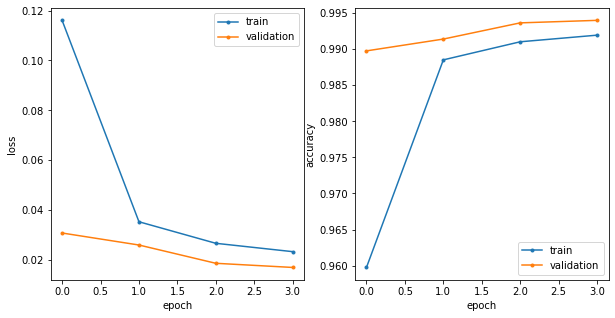

In [118]:
#====================================================================================================================
#Save the model. We can train further by loading this model in if required.
#symbol_recog.save("Symbol_Recognition_v5")
#====================================================================================================================

#Load version 5 of model.
symbol_recog = load_model('Symbol_Recognition_v5')

In [119]:
#Evaluate the model performance on the test symbol data
score = symbol_recog.evaluate(X_test_symbols, y_test_symbols_1h, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2051/2051 [==============================] - 59s 29ms/step - loss: 0.0215 - accuracy: 0.9923
Test loss: 0.021490268409252167
Test accuracy: 0.9922875165939331


In [120]:
#====================================================================================================================
#Get predictions for test data.
#Same logic as digit_eval() but we already know the image sizes.
#y_pred_symbols = []
symbol_classes = np.array(['+', '-', '[', ']', 'c', 'd']) #Order they are encoded by one-hot-encoder.

#for symbol in X_test_symbols:
    #result = symbol_recog.predict(np.array([symbol]))[0]
    #prediction_index = np.argmax(result)
    #y_pred_symbols.append(symbol_classes[prediction_index])

#y_pred_symbols = np.array(y_pred_symbols)    

#np.save('symbol_test_predictions_v5', y_pred_symbols, allow_pickle = True)
#====================================================================================================================
#Load predictions for version 5. Corresponds to NN version 5.
y_pred_symbols = np.load('symbol_test_predictions_v5.npy', allow_pickle = True)

In [121]:
y_train_symbols[0], y_train_symbols_1h[0]

(array([']'], dtype=object), array([0., 0., 0., 1., 0., 0.]))

In [122]:
y_train_symbols[1], y_train_symbols_1h[1]

(array(['['], dtype=object), array([0., 0., 1., 0., 0., 0.]))

In [123]:
y_train_symbols[-1], y_train_symbols_1h[-1]

(array(['c'], dtype=object), array([0., 0., 0., 0., 1., 0.]))

In [124]:
y_train_symbols[70000], y_train_symbols_1h[70000]

(array(['+'], dtype=object), array([1., 0., 0., 0., 0., 0.]))

In [125]:
y_train_symbols[100000], y_train_symbols_1h[100000]

(array(['d'], dtype=object), array([0., 0., 0., 0., 0., 1.]))

In [126]:
#Confusion matrix. Order is plus, minus, left bracket, right bracket, digit
pd.DataFrame(confusion_matrix(y_test_symbols, y_pred_symbols))
#There seems to be trouble predicting + and digits.

,0,1,2,3,4,5
0,8733,17,3,4,0,17
1,32,8336,4,0,0,4
2,9,0,8119,112,0,12
3,4,6,13,7360,0,19
4,0,0,0,0,16402,0
5,68,2,21,151,7,16153


In [127]:
#Classification report.
print(classification_report(y_test_symbols, y_pred_symbols))
#Some issues with predicting + as - or digit.
#Some issues with predicting digit as column.
#Some issue with predicting '[' as ']'

              precision    recall  f1-score   support

           +       0.99      1.00      0.99      8774
           -       1.00      1.00      1.00      8376
           [       0.99      0.98      0.99      8252
           ]       0.96      0.99      0.98      7402
           c       1.00      1.00      1.00     16402
           d       1.00      0.98      0.99     16402

    accuracy                           0.99     65608
   macro avg       0.99      0.99      0.99     65608
weighted avg       0.99      0.99      0.99     65608



## Equation Parsing and Solving
<a id='eq'></a>

Now we have our three neural networks for recognizing all parts of a simple matrix equation. The remaining piece is to construct the logic for identifying each part of an equation and computing the solution. The img_partition was designed with this purpose in mind as well as for deconstructing matrices.

Before proceeding, it is important to note that certain misclassifications will cause errors which terminate the program. They are usually index errors. We discuss these issues in the conclusion. All code before this point should run with no errors.

The first step is to split the image at white space into vertical columns. While doing this, we record the location of every partition. These locations give the right edge of a nonempty feature of the equation. We use the symbol recogntion neural networks for identifying these features. Thus, in its current form, the network detects digits, operations, brackets, and matrix columns.

Next, we check for matrices. This is done by looking between all pairs of adjacent brackets. The first attempt looked only between brackets where the left and right brackets were detected as left and right brackets respectively. As noted earlier, the neural network has trouble distinguishing between the brackets. This seems to be due to the rescaling. Thus we do not distinguish between left and right brackets in the logic.

For a given pair of adjacent brackets, we classify the subsection of the image given by those brackets and everything in between, using the matrix recognition neural network. In general, matrices seem to be correctly identified as matrices but this is where the operations between brackets became an issue. In fact, they are still an issue. There is also a problem with white space between two brackets being identified as a matrix. 

Instead of retraining the neural network to account for the white space and get better recall with the operations, we leverage the fact that there is a priori knowledge of the context of the input. We know that the image inputs have 0 pixel value where there are no features and we already use this technique for detecting where images are located. Thus, if we have something between two brackets with pixel values summing to 0, we know it can't be a matrix. We also know that operations between brackets look like a matrix column. We can strip away the brackets and white space as we would with a matrix. Then, we are left with a single row. Therefore, anything which the matrix detection neural network thinks is a matrix that has only one row, we feed in the entries to the symbol recognition neural network, which distinguishes between digits and operations much more accurately. If we detect an operation in the row, we know that we are not looking at a matrix.

After matrix identification is complete, we process each for entry identification. The brackets are removed, the matrix is partitioned into individual entries, and each entry is fed into the digit recognition neural network. The results are stored in a numpy array with the same shape as the matrix.

At this point, we have the location of all matrices. This also means that we have the location of all features of the image which are not part of a matrix. We take these objects and use the symbol recognition network to classify them since the remaining options are digits and operations.

Lastly, all features are stored in a list along with their locations and a string value to identify if they are a matrix, digit, or operation. The list is sorted by location so that the order is determined by how they appear in the equation. Then, we simply compute the answer. 

There is some logic required for computing the answer. First, the equation is partitioned into sections where a plus or minus is detected. Thus, each section has only the multiplication operation to perform. After multiplying everything in each section, we add and subtract as dictated by the operations we detected earlier. For the moment, multiplication is when a digit is next to a matrix or a matrix is next to a matrix. No multiplication operator has been implemented and no checking for compatible matrix dimensions has been added at this time.

We also provide some code to generate images of equations. Other options are provided as comments. The current option gives matrix multiplication fo two 2x2 matrices followed by the addition of a third 2x2 matrix.

In [128]:
#Generate a + or - operation.
index = np.random.randint(X_test_operations.shape[0], size = 1)
padding(X_test_operations[index]).shape

(1, 32, 32, 1)

In [129]:
#Add white space to fit operation to an image with 2x2 mtrices.
#s1 = np.vstack([np.zeros((32, 32, 1)), padding(X_test_operations[index])[0]])

#Add white space to fit operation to an image with 3x3 mtrices.
s1 = np.vstack([np.zeros((64, 32, 1)), padding(X_test_operations[index])[0]])

In [130]:
#Check shape.
s1.shape

(64, 32, 1)

In [162]:
#Generate a random digit.
index2 = np.random.randint(X_test_digits_padded.shape[0], size = 1)
X_test_digits_padded[index2].shape

(1, 32, 32, 1)

In [163]:
#Add white space to fit digit to an image with 2x2 mtrices.
#d1 = np.vstack([np.zeros((32, 32, 1)), X_test_digits_padded[index2][0]])

#Add white space to fit digit to an image with 3x3 mtrices.
d1 = np.vstack([np.zeros((64, 32, 1)), X_test_digits_padded[index2][0]])

d1.shape

(96, 32, 1)

In [185]:
#Generate 2x2 matrices.
#m1 = synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2)
#m2 = synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2)
#m3 = synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets), 2, 2)

#Generate 3x3 matrices.
m4 = synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets))
m5 = synth_mat(X_test_digits_padded, np.array(lbrackets), np.array(rbrackets))

In [186]:
#Multiply two 2x2 matrices and add a third.
#img = np.concatenate([m1, m2, s1, m3], axis = 1)

#multiply three 2x2 matrices.
#img = np.concatenate([m1, m2, m3], axis = 1)

#multiply two 3x3 matrices.
img = np.concatenate([m4, m5], axis = 1)

#Multiply a matrix by a digit.
#img = np.concatenate([d1, m4], axis = 1)

#Add or subtract two 3x3 matrices.
#img = np.concatenate([m4, s1, m5], axis = 1)

#Add or subtract two 2x2 matrices.
#img = np.concatenate([m1, s1, m2], axis = 1)

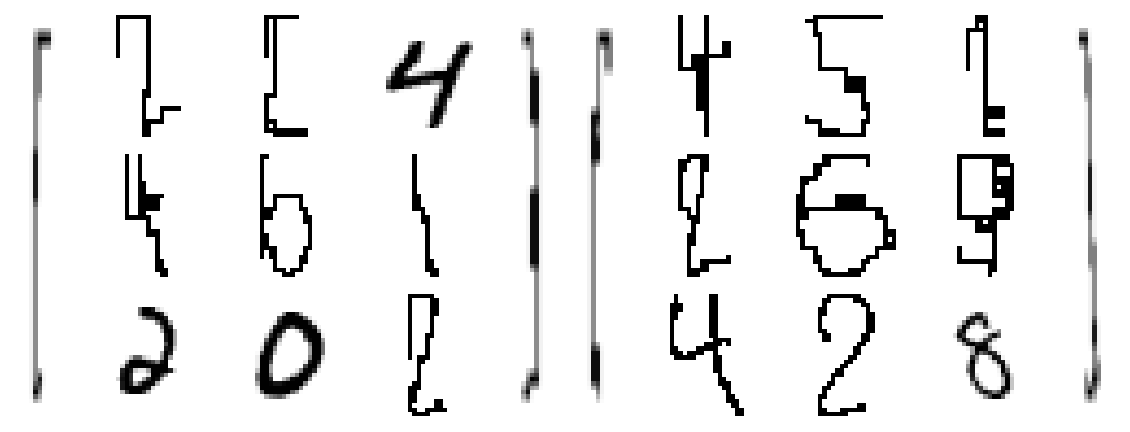

In [187]:
#Check the image of the equation.
plt.figure(figsize = (20,20))
plt.imshow(img, cmap = 'gray_r', vmin = 0, vmax = 1)
plt.axis('off')
plt.show()

In [188]:
#Partition image into 'columns'.
partitions = img_partition(img, 'col', 1)
#Store where left and right brackets are located.
brac_loc = []

#Look at one column slice of the image at a time.
for i in range(0, len(partitions)):
    if (i == 0):
        part = img[:, 0 : partitions[i]]
    else:
        part = img[:, partitions[i - 1] : partitions[i]]

    if ((part.shape[0] == 32) & (part.shape[1] == 32)):
        #If the image already has the correct dimensions, we can feed it into our model and get the class predictions.
        #The .predict requires an array input.
        result = symbol_recog.predict(np.array([part]))[0]
    else:
        #If image is too big in at least one dimension.
        if ((part.shape[0] > 32) | (part.shape[1] > 32)):
            #If the part of the image is still too big after being cropped.
            if ((digit_cropping(part).shape[0] > 32) | (digit_cropping(part).shape[1] > 32)):
                #It is a column or a bracket.
                #Resize to make image the correct dimensions for NN and predict.
                result = symbol_recog.predict(np.array([resize(part, (32, 32, 1))]))[0]
            else:
                #The image is a digit or a symbol
                result = symbol_recog.predict(padding(np.array([digit_cropping(part)])))[0]
        else:
            #Pad to get dimensions for neural network input. Predict digit class.
            result = symbol_recog.predict(padding(np.array([part])))[0]
            
    #Predicted class is largest value in result array.
    #argmax returns the index corresponding to the maximum entry.
    prediction = symbol_classes[np.argmax(result)]
    
    #print predictions for each vertical strip for testing purposes. 
    print(prediction)
    
    #If a bracket is detected, store where a matrix may start or stop.
    #Store a box around the bracket since it may be the start or end of a matrix.
    if ((prediction == '[') | (prediction == ']')):
        if (i == 0):
            brac_loc.append([0, partitions[i]])
        else:
            brac_loc.append([partitions[i - 1], partitions[i]])


]
c
c
c
]
]
c
c
c
]


In [189]:
#Check locations of brackets.
brac_loc

[[0, 11], [107, 123], [123, 140], [231, 255]]

In [190]:
#Store left and right edges of matrices and an array of the predicted entries with the same dimensions.
mat_loc = []

#There are len(brac_loc) - 1 parts of the image in between brackets.
for j in range(0, len(brac_loc) - 1):
    #Image of brackets and everything in between. Thus a potential matrix.
    mat = img[:, brac_loc[j][0] : brac_loc[j + 1][1]]
    
    if ((mat.shape[0] == 32) & (mat.shape[1] == 32)):
        #If the image already has the correct dimensions, we can feed it into our model and get the class predictions.
        #The .predict requires an array input.
        result = matrix_recog.predict(np.array([mat]))[0]
    else:
        #If image is too big in at least one dimension.
        if ((mat.shape[0] > 32) | (mat.shape[1] > 32)):
                #Resize to make image the correct dimensions for NN and predict.
                result = matrix_recog.predict(np.array([resize(mat, (32, 32, 1))]))[0] 
        else:
            #Pad to get dimensions for neural network input. Predict digit class.
            result = matrix_recog.predict(padding(np.array([mat])))[0]
            
    #Predicted class is largest value in result array.
    #argmax returns the index corresponding to the maximum entry.
    prediction = mat_classes[np.argmax(result)]
   
    #If matrix is predicted.
    if (prediction == 'm'):
        #The commented code plots the predicted matrix for testing and demonstration purposes.
        #plt.figure()
        #plt.imshow(mat, cmap = 'gray_r', vmin = 0, vmax = 1)
        #plt.axis('off')
        #plt.show()
        
        #Remove brackets.
        mat = bracket_removal(mat)
        
        #Currently predicts ][ as a matrix. 
        #After removing brackets, we just have white space so this is a work-around for now.
        #We are summing all pixel values. Nonzero sum means something is between the brackets.
        if (float(sum(sum(mat))) > 0):
            #Get rows and columns.
            col_part = img_partition(mat, 'col', 1)
            row_part = img_partition(mat, 'row', 1)
  
            #Store matrix entries.
            entries = []
            #Get the individual matrix entries. We already have right edges and bottom edges stored.
            for n in range(0, len(row_part)):
                #Top edge of entry image.
                if (n == 0):
                    top = 0
                else:
                    top = row_part[n - 1]

                for k in range(0, len(col_part)):
                    #Left edge of entry image.
                    if (k == 0):
                        left = 0
                    else:
                        left = col_part[k - 1]
                    
                    entries.append(mat[top : row_part[n], left : col_part[k]])
                    
                    #The commented code below plots theimage of the matrix entry for testing and demonstration purposes.
                    #plt.figure()
                    #plt.imshow(mat[top : row_part[n], left : col_part[k]], cmap = 'gray_r', vmin = 0, vmax = 1)
                    #plt.axis('off')
                    #plt.show()
                    
            #If only one row is detected, we check that no 'entries' are + or -.
            #Initialize variable to store whether we really have a matrix or not.
            not_a_matrix = False
            if (len(row_part) == 1):
                for k in range(0, len(col_part)):
                    check_result = symbol_recog.predict(padding(np.array([digit_cropping(entries[k])])))[0]
                    check_prediction = symbol_classes[np.argmax(check_result)]
                    if ((check_prediction == '+') | (check_prediction == '-')):
                        not_a_matrix = True
            if (not_a_matrix == False):
                #Note that we assume matrix has at least two entries. A 1x1 matrix will be treated as a digit.
                #Get array of matrix entries in the form of input image.
                mat_pred = digit_eval(entries).reshape(len(row_part), len(col_part))
                #Store the left and right edges of the matrix. This excludes several partitions of the original image in between.
                mat_loc.append((brac_loc[j][0], brac_loc[j + 1][1], mat_pred, 'm')) #m for matrix

In [191]:
#Check matrix location and entries after predictions.
mat_loc

[(0,
  123,
  array([[2, 2, 4],
         [4, 6, 1],
         [2, 0, 1]], dtype=int64),
  'm'),
 (123,
  255,
  array([[4, 5, 1],
         [2, 6, 9],
         [4, 2, 8]], dtype=int64),
  'm')]

In [192]:
#Check partitions of equation image.
partitions

[11, 40, 73, 107, 123, 140, 169, 204, 231, 255]

In [193]:
#Check the rest of the image for digits and symbols.
sym_loc = []

for p in range(0, len(partitions)):
    #Keep track of if a partition of the image corresponds to part of a matrix.
    #Initialize to false means we assume it is not part of a matrix until proven otherwise.
    in_mat = False
    for i in range(0, len(mat_loc)):
        #If partition is between the left and right edge of a matrix.
        #Note partition is a right edge of a feature we do not want to throw away partition = mat_loc[i][0].
        if ((partitions[p] > mat_loc[i][0]) & (partitions[p] <= mat_loc[i][1])):
            #Partition is inside a matrix.
            in_mat = True
    
    #If partitions is the right edge of something not inside a matrix.
    if (in_mat == False):
        #Right edge.
        right = partitions[p]
        #Left edge.
        if (p == 0):
            left = 0
        else:
            left = partitions[p - 1]
        
        #Select the part of the image we are predictiong.    
        part = img[:, left : right]
        
        #We will assume brackets will not appear in cases other than defining matrices for now.
        
        if ((part.shape[0] == 32) & (part.shape[1] == 32)):
            #If the image already has the correct dimensions, we can feed it into our model and get the class predictions.
            #The .predict requires an array input.
                result = symbol_recog.predict(np.array([part]))[0]
        else:
            #This is where we assume no brackets. All other symbols have been padded to 32x32x1 before making the image.
            #Thus, after removing the white space, the image will be too small.
            #Remove extra white space. digit_cropping() will work for plus and minus as well.
            part = digit_cropping(part)
            #Pad to get dimensions for neural network input. Predict symbol class.
            result = symbol_recog.predict(padding(np.array([part])))[0]
            
        #Predicted class is largest value in result array.
        #argmax returns the index corresponding to the maximum entry. 
        prediction = symbol_classes[np.argmax(result)]
        
        #Print statement for debugging and demonstration.
        print(prediction)
        
        #If we predict a plus or minus operation.
        if ((prediction == '+') | (prediction == '-')):
            #Store location and prediction.
            sym_loc.append((left, right, prediction, 'o')) #o for operation
        #If we predict a digit.
        elif (prediction == 'd'):
            #Predict the digit.
            sym_loc.append((left, right, digit_eval(np.array([part])), 'd')) #d for digit

In [194]:
#Check location and prediction of symbols.
sym_loc

[]

In [195]:
#Store locations of symbols and matrices together.
if (len(sym_loc) > 0):
    #eq_loc = np.concatenate([np.array(sym_loc), np.array(mat_loc)], axis = 0)
    eq_loc = sym_loc + mat_loc
else:
    eq_loc = mat_loc

In [196]:
#Check list of equation features.
eq_loc

[(0,
  123,
  array([[2, 2, 4],
         [4, 6, 1],
         [2, 0, 1]], dtype=int64),
  'm'),
 (123,
  255,
  array([[4, 5, 1],
         [2, 6, 9],
         [4, 2, 8]], dtype=int64),
  'm')]

In [197]:
#Sort by the first entries (left edges of features).
#This gives the order of features as they appear.      

from operator import itemgetter
eq_loc = sorted(eq_loc, key = itemgetter(0))

In [198]:
#Check equation features after sorting by order of appearance.
eq_loc

[(0,
  123,
  array([[2, 2, 4],
         [4, 6, 1],
         [2, 0, 1]], dtype=int64),
  'm'),
 (123,
  255,
  array([[4, 5, 1],
         [2, 6, 9],
         [4, 2, 8]], dtype=int64),
  'm')]

In [199]:
#Initialize index variables
i = 0
j = 0
#Number of sub-equations is one more than the number of +/- operations
num_sub_eq = 1
for t in range(0, len(sym_loc)):
    if (sym_loc[t][3] == 'o'):
        num_sub_eq = num_sub_eq + 1

#Initialize empty list of lists to store sub-equations.
sub_eq = []
for k in range(0, num_sub_eq):
    sub_eq.append([])

#Assuming input doesn't start with an operation symbol.
while (j < num_sub_eq):
    while (eq_loc[i][3] != 'o'):
        sub_eq[j].append(eq_loc[i])
        i = i + 1
        if (i >= len(eq_loc)):
            break
    j = j + 1
    i = i + 1
    
#Store results of sub-equation multiplications.
results = []    

#Calculate for each sub-equation.
for j in range(0, num_sub_eq):
    #Initialize result of multiplication to first value.
    result = sub_eq[j][0]
    #Multiply the elements of the sub-equation together.
    for k in range(1, len(sub_eq[j])):
        #If we multiply two digits.
        if ((result[3] == 'd') & (sub_eq[j][k][3] == 'd')):
            #The 0 functions as a placeholder since we no longer need that information.
            result = (0, 0, result[2] * sub_eq[j][k][2], 'd')
        #If we multiply a matrix by a digit.
        elif ((result[3] == 'd') | (sub_eq[j][k][3] == 'd')):
            result = (0, 0, result[2] * sub_eq[j][k][2], 'm')
        #If we multiply two matrices.
        else:
            result = (0, 0, np.matmul(result[2], sub_eq[j][k][2]), 'm')
    
    #Store only result of multiplication.
    results.append(result[2])

#initialize answer to result of first sub-equation.
answer = results[0]

#Initialize counter to keep track of which sub equation we will add or subtract
results_counter = 1
#Add and subtract results from sub-equations based on operations detected.
for i in range(0, len(sym_loc)):
    #If operation is addition.
    if (sym_loc[i][2] == '+'):
        answer = answer + results[resuts_counter]
        #Increase counter.
        results_counter = results_counter + 1
    #If operation is subtraction.
    elif (sym_loc[i][2] == '-'):
        answer = answer - results[results_counter]
        #Increase counter.
        results_counter = results_counter + 1
    
print(answer)

[[28 30 52]
 [32 58 66]
 [12 12 10]]


In [200]:
#Shows the partitions of the equation image.
#plt.figure(figsize = (20,20))
#plt.imshow(img, cmap = 'gray_r', vmin = 0, vmax = 1)
#plt.vlines(partitions, ymin = 0, ymax = 64, colors = 'red')
#plt.axis('off')
#plt.show()

## Conclusion
<a id='conclusion'></a>

There are several significant issues with this project which prevents it from being particularly useful. On the surface, the neural networks all have high accuracy, precision, and recall. However, these are not good metrics to evaluate the project since they do not evaluate performance on outputting solutions to equations. The first issue is that each neural network classifies specific features of an equation and each equation has many features. For example, multiplying two 3x3 matrices has 18 digits, 4 brackets, 6 columns, and 2 matrices to classify. This adds up to 30 separate classifications in a very simple equation. Treating each classification as a Bernoulli trial, even with 99% accuracy for all predictions, we end up with about a 30% chance to encounter an error. This illustrates why it is important to leverage the context built into the equations. 

A better model performance metric would be the accuracy in correct solution output. This is something we would like to implement but it requires a bit more work. Certain classification errors will cause errors which terminate the program. Thus, we need to include try-except statements and bin the error-producing equations with incorrectly predicted equations. This would also require synthesizing many more equations. We could also calculate this metric by hand since we have the relevant statistical information available from the classification reports.

There are three possible courses of action which we think would improve performance. The first and most simple involves using the fact that the symbol recognition neural network performs well on matrix columns. We do not use this information beyond helping to distinguish between brackets and not brackets. We could add the column predctions to help determine where to look for a matrix and reduce classification errors. For example, an issue that arises is a bracket may be classified as a plus sign. The equation parsing logic would then check the wrong subsection of the image for a matrix. The added layer of classification could be that if we have an operation and then columns or columns and then an operation, we likely misclassified brackets as an operation. Thus we should check the columns and the two adjacent non-columns to see if it is actually a matrix.

The second possible improvement is adding more specialized neural networks to create a classification sieve. For example, the first layer of symbol detection could classify all binary operations as the same class. Then we use a second neural network which is trained only to distinguish between the relevant binary operations. In a sense, this is the method we already use, but it can be further refined.

The last course of action is to train a neural network on entire types of equations. For example, we train a neural network to recognize multiplying two matrices of a given size. This would eliminate the number of classifications which would need to be correct in order to identify what type of equation is in the image. Going back to the example for multiplying two 3x3 matrices, it could reduce the problem from 30 classifications to 19 classifications. The first would be if it is a multiplication of two 3x3 matrices and the remaining 18 are simply identifying matrix entries.

Note that the three proposed improvements are not mutually exclusive and employing all of them may be the best way forward.

Recall that we did not distinguish between left and right brackets in the equation parsing logic. It would then make more sense to not distinguish between them in training a model. This could potentially improve model performance. We could also attempt to use some image processing techniques to sharpen the bracket images before classification. This could offset the data loss from resizing the brackets twice.

We made assumptions on the input images which we feel are not reasonable for a model expected to be useful on real data. The most significant assumptions involve where white space is located in relation to the relevant pieces of the equation. All input images are aligned too precisely. Many people do not write in a straight line across a page unless they have something to guide them. Matrix rows and columns are also often not aligned very well and brackets often reach over into the first and last columns. As a result, scanning through an image with a vertical or horizontal box in which the long dimension matches that of the image is not practical. A slanted image of a 3x3 matrix would register as one feature instead of many.

A possible remedy is to scan through smaller parts of the image, similar to the bracket_removal function. However, this method in its current form involve a preset scan box dimension which would still require certain assumptions on image input and feature spacing. 

Another related consideration is we did not add randomness in digit and bracket spacing. In fact, we could add some random shifts while maintaining the current requirement of white space separation. 

Our method of feature detecting relies on the fact that the images contain no noise. The white space is entirely pixels with value 0. A possible solution here would be to simply establish a baseline for the input. For example, maybe white space, when the pixels are scaled between 0 and 1, would have values below 0.001. Thus, given the image size, we would know the sum of pixel values for a strip of white space. Of course, this would only work for a small subset of writing surfaces. Moreover, unless we can detect the writing surface from the input, we would need to know this information in advance.

Some other improvements would be to allow for numbers other than 0 to 9, more operations and types of equations, and English and Greek characters. 

In conclusion, the simple convolutional neural networks were very effective as a tool for experimentation. However, a more sophisticated model and larger input image dimensions could be beneficial. Building a classification sieve with more layers of networks and some more image processing also seem like necessary improvements if we wish to scale the project. We think that much more matrix data should be synthesized and the matrix recognition model should be able to identify row and column vectors and nonsquare matrices. 

However, for simple equations, this program is able to produce a decent result and the general methodology could be used to create something more useful. A clearer model performance metric is needed but the naive metrics given throughout the project can serve as an alternative given they are interpreted carefully in the context of an input equation.